In [100]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


#savedir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/'
#savedir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation_latent_256/'
savedir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/'
#dfs_dir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/embeddings/ukb40_epoch80_embeddings'
#dfs_dir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation_latent_256/embeddings/ukb40_epoch80_embeddings'
n_dims = 32

regions_to_treat = ['SOr_left',
 'SOr_right',
 'FColl-SRh_left',
 'SFmedian-SFpoltr-SFsup_left',
 'SFinf-BROCA-SPeCinf_left',
 'SPoC_left',
 'fronto-parietal_medial_face_left',
 'FIP_left',
 'CINGULATE_left',
 'SC-SPoC_left',
 'SFinter-SFsup_left',
 'FCMpost-SpC_left',
 'SsP-SPaint_left',
 'SOr-SOlf_left',
 'FPO-SCu-ScCal_left',
 'LARGE_CINGULATE_left',
 'SFmarginal-SFinfant_left',
 'SFint-FCMant_left',
 'STi-STs-STpol_left',
 'SFint-SR_left',
 'Lobule_parietal_sup_left',
 'STi-SOTlat_left',
 'SPeC_left',
 'STsbr_left',
 'ScCal-SLi_left',
 'STs_left',
 'FCLp-subsc-FCLa-INSULA_left',
 'SC-sylv_left',
 'SC-SPeC_left',
 'OCCIPITAL_left',
 'FColl-SRh_right',
 'SFmedian-SFpoltr-SFsup_right',
 'SFinf-BROCA-SPeCinf_right',
 'SPoC_right',
 'fronto-parietal_medial_face_right',
 'FIP_right',
 'CINGULATE_right',
 'SC-SPoC_right',
 'SFinter-SFsup_right',
 'FCMpost-SpC_right',
 'SsP-SPaint_right',
 'SOr-SOlf_right',
 'FPO-SCu-ScCal_right',
 'LARGE_CINGULATE_right',
 'SFmarginal-SFinfant_right',
 'SFint-FCMant_right',
 'STi-STs-STpol_right',
 'SFint-SR_right',
 'Lobule_parietal_sup_right',
 'STi-SOTlat_right',
 'SPeC_right',
 'STsbr_right',
 'ScCal-SLi_right',
 'STs_right',
 'FCLp-subsc-FCLa-INSULA_right',
 'SC-sylv_right',
 'SC-SPeC_right',
 'OCCIPITAL_right']

In [101]:
# function to make correspondance between IDs
def make_correspondance_ids(df1, df2, colname='ID2'):
    """
    Make correspondance between IDs. Adds column ID2 to df1.
    """

    new_df = df1.copy()

    id2_dict = {}
    for id1 in df1['ID'].values:
        filtered_df2 = df2[df2['ID'].apply(lambda x: (x in id1) or (id1 in x))]
        id2 = filtered_df2['ID'].tolist()
        if len(id2) > 0:
            id2 = id2[0]
            id2_dict[id1] = id2
    new_df[colname] = new_df['ID'].map(id2_dict)
    new_df = new_df.dropna()
    return new_df   

# ASD

In [98]:
# select the train val subjects
dataset = 'agg_abide'
all_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/aggregate_autism/all_subjects.csv')
all_subjects.columns = ['ID']
splits_dir = '/neurospin/dico/data/deep_folding/current/datasets/aggregate_autism/splits/'
train_val_subjects_dirs = glob.glob(f'{splits_dir}/train_val_*')
# load each split subject file and create cv splits from them
train_val_subjects = []
for i, directory in enumerate(train_val_subjects_dirs):
    train_val_subjects.append(pd.read_csv(directory, sep='\t', header=None))
train_val_subjects = pd.concat(train_val_subjects, axis=0)
train_val_subjects.columns = ['ID']
train_val_subjects['ID'] = train_val_subjects['ID'].astype(str)

# select the test subjects
test_subjects = pd.read_csv(f'{splits_dir}/internal_test.csv', header=None)
test_subjects.columns = ['ID']
test_subjects['ID'] = test_subjects['ID'].astype(str)
# select the test extra
test_extra_subjects = pd.read_csv(f'{splits_dir}/external_test.csv', header=None)
test_extra_subjects.columns = ['ID']
test_extra_subjects['ID'] = test_extra_subjects['ID'].astype(str)

# print lengths
print(f'nb train val : {len(train_val_subjects)}, nb test : {len(test_subjects)}, nb test extra : {len(test_extra_subjects)}')

# load labels
labels1 = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/abide1/20231108_participants.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels2 = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/abide2/20231108_participants.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels = pd.concat([labels1, labels2], axis=0)
labels.columns = ['ID'] + labels.columns[1:].tolist()
labels.dropna()
print(np.unique(labels['diagnosis'], return_counts=True))
label = 'diagnosis'
pathology = 'asd'
print(f'nb labels : {len(labels)}')

nb train val : 1462, nb test : 161, nb test extra : 116
(array(['asd', 'control'], dtype=object), array([1057, 1158]))
nb labels : 2215


In [99]:
## group the train val and test subjects # DO NOT CONSIDER TEST EXTRA SUBJECTS
train_val_test_subjects = pd.concat([train_val_subjects, test_subjects], axis=0)
train_val_test_subjects['ID'] = train_val_test_subjects['ID'].astype(str)
print(len(train_val_test_subjects))

1623


In [100]:
# merge train_val_test and labels
df = make_correspondance_ids(labels, train_val_test_subjects, colname='ID_train_val_test')
# merge df and all_subjects
df = make_correspondance_ids(df, all_subjects, colname='ID_all_subjects')
# drop
df = df.drop_duplicates()
df = df.dropna()
df.columns = ['ID_labels', 'sex', 'age', 'diagnosis', 'site', 'ID_train_val_test', 'ID']

In [101]:
df

,ID_labels,sex,age,diagnosis,site,ID_train_val_test,ID
0,sub-51456,M,55.400000,asd,CALTECH,51456,sub-51456
1,sub-51457,M,22.900000,asd,CALTECH,51457,sub-51457
2,sub-51458,M,39.200000,asd,CALTECH,51458,sub-51458
3,sub-51459,M,22.800000,asd,CALTECH,51459,sub-51459
4,sub-51460,F,34.600000,asd,CALTECH,51460,sub-51460
...,...,...,...,...,...,...,...
1096,sub-28894,M,11.200000,control,SDSU,28894,sub-28894_ses-1_run-1
1097,sub-29559,M,19.000000,asd,IU,29559,sub-29559_ses-1_run-1
1098,sub-29222,M,14.980000,asd,NYU_1,29222,sub-29222_ses-1_run-1
1099,sub-29093,M,20.166667,control,ETH,29093,sub-29093_ses-1_run-1


In [102]:
print('Number of sites', len(np.unique(df['site'])))

Number of sites 30


In [103]:
# check male female distribution
print(f"Male {pathology} : {df.loc[(df['sex']=='M')&(df['diagnosis']!='control')].shape[0]}")
print(f"Male control : {df.loc[(df['sex']=='M')&(df['diagnosis']=='control')].shape[0]}")
print(f"Female {pathology} : {df.loc[(df['sex']=='F')&(df['diagnosis']!='control')].shape[0]}")
print(f"Female control : {df.loc[(df['sex']=='F')&(df['diagnosis']=='control')].shape[0]}")
print('total nb of subjects : ', df.shape[0])

Male asd : 655
Male control : 660
Female asd : 96
Female control : 197
total nb of subjects :  1608


In [104]:
# check age distribution
pathology_age = df.loc[df['diagnosis']!='control']['age'].tolist()
control_age = df.loc[df['diagnosis']=='control']['age'].tolist()

print(f'mean {pathology} age : ', np.mean(pathology_age))
print('mean control age : ', np.mean(control_age))
print(f'std {pathology} age : ', np.std(pathology_age))
print('std control age : ', np.std(control_age))

mean asd age :  16.32560377754594
mean control age :  16.47036283142707
std asd age :  9.118436819850027
std control age :  9.265514294158164


# Bipolar

In [674]:
# select the train val subjects
dataset = 'bipolar'
all_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/aggregate_bipolar/all_subjects.csv')
all_subjects.columns = ['ID']
splits_dir = '/neurospin/dico/data/deep_folding/current/datasets/aggregate_bipolar/splits/'
train_val_subjects_dirs = glob.glob(f'{splits_dir}/train_val_*')
# load each split subject file and create cv splits from them
train_val_subjects = []
for i, directory in enumerate(train_val_subjects_dirs):
    train_val_subjects.append(pd.read_csv(directory, sep='\t', header=None))
train_val_subjects = pd.concat(train_val_subjects, axis=0)
train_val_subjects.columns = ['ID']
train_val_subjects['ID'] = train_val_subjects['ID'].astype(str)

# select the test subjects
test_subjects = pd.read_csv(f'{splits_dir}/internal_test.csv', header=None)
test_subjects.columns = ['ID']
test_subjects['ID'] = test_subjects['ID'].astype(str)
# select the test extra
test_extra_subjects = pd.read_csv(f'{splits_dir}/external_test.csv', header=None)
test_extra_subjects.columns = ['ID']
test_extra_subjects['ID'] = test_extra_subjects['ID'].astype(str)

# print lengths
print(f'nb train val : {len(train_val_subjects)}, nb test : {len(test_subjects)}, nb test extra : {len(test_extra_subjects)}')

# load labels
labels1 = pd.read_csv('/neurospin/psy/biobd/participants_v-2023_ld.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels2 = pd.read_csv('/neurospin/psy/bsnip1/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels3 = pd.read_csv('/neurospin/psy/candi/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age'], sep='\t')
labels3['site'] = ['CANDI'] * len(labels3)
labels4 = pd.read_csv('/neurospin/psy/cnp/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'ScannerSerialNumber'], sep='\t')
labels4['ScannerSerialNumber'] = labels4['ScannerSerialNumber'].apply(lambda x: str(int(x)))
labels4.columns=['participant_id', 'diagnosis', 'sex', 'age', 'site']
labels = pd.concat([labels1, labels2, labels3, labels4], axis=0)
labels.columns = ['ID'] + labels.columns[1:].tolist()
labels.dropna()
label = 'diagnosis'
pathology = 'bipolar'
# not only bipolar
print(np.unique(labels['diagnosis'], return_counts=True))
# drop rows for which diagnosis is not control or pathology
labels = labels[labels[label].isin(['control', 'bipolar', 'bd', 'psychotic bd', 'bipolar disorder'])]
labels['ID'] = labels['ID'].astype(str)
print(f'nb labels : {len(labels)}')

nb train val : 932, nb test : 106, nb test extra : 131
(array(['F', 'M', 'bd', 'bipolar disorder', 'control', 'psychotic bd',
       'relative of bipolar disorder',
       'relative of schizoaffective disorder',
       'relative of schizophrenia', 'schizoaffective disorder', 'scz'],
      dtype=object), array([117, 155,  35, 343, 660, 140, 122, 134, 176, 124, 216]))
nb labels : 1178


In [675]:
## group the train val and test subjects # DO NOT CONSIDER TEST EXTRA SUBJECTS
train_val_test_subjects = pd.concat([train_val_subjects, test_subjects], axis=0)
train_val_test_subjects['ID'] = train_val_test_subjects['ID'].astype(str)
print(len(train_val_test_subjects))

1038


In [676]:
# merge train_val_test and labels
df = make_correspondance_ids(labels, train_val_test_subjects, colname='ID_train_val_test')
# merge df and all_subjects
df = make_correspondance_ids(df, all_subjects, colname='ID_all_subjects')
# drop
df = df.drop_duplicates()
df = df.dropna()
df.columns = ['ID_labels', 'sex', 'age', 'diagnosis', 'site', 'ID_train_val_test', 'ID']

In [677]:
df

,ID_labels,sex,age,diagnosis,site,ID_train_val_test,ID
0,972062114583,F,42.91,control,sandiego,972062114583,sub-972062114583_ses-V1_run-1
2,507444321409,M,53.0,control,creteil,507444321409,sub-507444321409_ses-V1_run-1
3,510905297072,M,42.097194,control,udine,510905297072,sub-510905297072_ses-V1_run-1
4,683853218873,F,38.0,control,galway,683853218873,sub-683853218873_ses-V1_run-1
5,813311935665,F,45.0,control,pittsburgh,813311935665,sub-813311935665_ses-V1_run-1
...,...,...,...,...,...,...,...
78,sub-HC025,M,9.6,control,CANDI,HC025,sub-HC025
79,sub-HC026,M,7.4,control,CANDI,HC026,sub-HC026
80,sub-HC027,M,5.2,control,CANDI,HC027,sub-HC027
81,sub-HC028,M,14.26,control,CANDI,HC028,sub-HC028


In [678]:
print('Number of sites', len(np.unique(df['site'])))

Number of sites 13


In [679]:
# check male female distribution
print(f"Male {pathology} : {df.loc[(df['sex']=='M')&(df['diagnosis']!='control')].shape[0]}")
print(f"Male control : {df.loc[(df['sex']=='M')&(df['diagnosis']=='control')].shape[0]}")
print(f"Female {pathology} : {df.loc[(df['sex']=='F')&(df['diagnosis']!='control')].shape[0]}")
print(f"Female control : {df.loc[(df['sex']=='F')&(df['diagnosis']=='control')].shape[0]}")

# fraction of male / female
df_patho = df.loc[df['diagnosis']!='control']
frac_f = len(df_patho.loc[df_patho['sex']=='F']) / len(df_patho)
print(f"Fraction F in {pathology} : {frac_f}")

df_control = df.loc[df['diagnosis']=='control']
frac_f = len(df_control.loc[df_control['sex']=='F']) / len(df_control)
print(f"Fraction F in control : {frac_f}")

Male bipolar : 143
Male control : 222
Female bipolar : 211
Female control : 282
Fraction F in bipolar : 0.596045197740113
Fraction F in control : 0.5595238095238095


In [680]:
# check age distribution
pathology_age = df.loc[df['diagnosis']!='control']['age'].tolist()
control_age = df.loc[df['diagnosis']=='control']['age'].tolist()

print(f'mean {pathology} age : ', np.mean(pathology_age))
print('mean control age : ', np.mean(control_age))
print(f'std {pathology} age : ', np.std(pathology_age))
print('std control age : ', np.std(control_age))

mean bipolar age :  39.312318483050845
mean control age :  38.32409417857143
std bipolar age :  11.846467189173392
std control age :  14.35433750285847


# Schizophrenia

In [266]:
# select the train val subjects
dataset = 'schiz'
all_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/aggregate_schizophrenia/all_subjects.csv')
all_subjects.columns = ['ID']
splits_dir = '/neurospin/dico/data/deep_folding/current/datasets/aggregate_schizophrenia/splits/'
train_val_subjects_dirs = glob.glob(f'{splits_dir}/train_val_*')
# load each split subject file and create cv splits from them
train_val_subjects = []
for i, directory in enumerate(train_val_subjects_dirs):
    train_val_subjects.append(pd.read_csv(directory, sep='\t', header=None))
train_val_subjects = pd.concat(train_val_subjects, axis=0)
train_val_subjects.columns = ['ID']
train_val_subjects['ID'] = train_val_subjects['ID'].astype(str)

# select the test subjects
test_subjects = pd.read_csv(f'{splits_dir}/internal_test.csv', header=None)
test_subjects.columns = ['ID']
test_subjects['ID'] = test_subjects['ID'].astype(str)
# select the test extra
test_extra_subjects = pd.read_csv(f'{splits_dir}/external_test.csv', header=None)
test_extra_subjects.columns = ['ID']
test_extra_subjects['ID'] = test_extra_subjects['ID'].astype(str)

# print lengths
print(f'nb train val : {len(train_val_subjects)}, nb test : {len(test_subjects)}, nb test extra : {len(test_extra_subjects)}')

# load labels
labels1 = pd.read_csv('/neurospin/psy/schizconnect-vip-prague/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels2 = pd.read_csv('/neurospin/psy/bsnip1/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels3 = pd.read_csv('/neurospin/psy/candi/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age'], sep='\t')
labels3['site'] = ['CANDI'] * len(labels3)
labels4 = pd.read_csv('/neurospin/psy/cnp/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'ScannerSerialNumber'], sep='\t')
labels4['ScannerSerialNumber'] = labels4['ScannerSerialNumber'].apply(lambda x: str(int(x)))
labels4.columns=['participant_id', 'diagnosis', 'sex', 'age', 'site']
labels = pd.concat([labels1, labels2, labels3, labels4], axis=0)
labels.columns = ['ID'] + labels.columns[1:].tolist()
labels.dropna()
label = 'diagnosis'
pathology = 'schizophrenia'
# not only bipolar
print(np.unique(labels['diagnosis'], return_counts=True))
# drop rows for which diagnosis is not control or pathology
labels = labels[labels[label].isin(['control', 'schizoaffective disorder', 'scz'])]
labels['ID'] = labels['ID'].astype(str)
print(f'nb labels : {len(labels)}')

nb train val : 1044, nb test : 118, nb test extra : 130
(array(['F', 'M', 'bd', 'control', 'fep', 'psychotic bd',
       'relative of bipolar disorder',
       'relative of schizoaffective disorder',
       'relative of schizophrenia', 'schizoaffective disorder', 'scz'],
      dtype=object), array([117, 155,  35, 667,  43, 140, 122, 134, 176, 124, 491]))
nb labels : 1282


In [267]:
## group the train val and test subjects # DO NOT CONSIDER TEST EXTRA SUBJECTS
train_val_test_subjects = pd.concat([train_val_subjects, test_subjects], axis=0)
train_val_test_subjects['ID'] = train_val_test_subjects['ID'].astype(str)
print(len(train_val_test_subjects))

1162


In [268]:
# merge train_val_test and labels
df = make_correspondance_ids(labels, train_val_test_subjects, colname='ID_train_val_test')
# merge df and all_subjects
df = make_correspondance_ids(df, all_subjects, colname='ID_all_subjects')
# drop
df = df.drop_duplicates()
df = df.dropna()
df.columns = ['ID_labels', 'sex', 'age', 'diagnosis', 'site', 'ID_train_val_test', 'ID']

In [269]:
df

,ID_labels,sex,age,diagnosis,site,ID_train_val_test,ID
0,sub-A00000300,M,36.0,control,MRN,A00000300,sub-A00000300
1,sub-A00000368,M,52.0,scz,MRN,A00000368,sub-A00000368
2,sub-A00000456,M,53.0,scz,MRN,A00000456,sub-A00000456
3,sub-A00000838,M,29.0,scz,MRN,A00000838,sub-A00000838
4,sub-A00000909,M,27.0,scz,MRN,A00000909,sub-A00000909
...,...,...,...,...,...,...,...
98,sub-SS099,F,16.19,scz,CANDI,SS099,sub-SS099
99,sub-SS100,F,8.42,scz,CANDI,SS100,sub-SS100
100,sub-SS101,M,11.75,scz,CANDI,SS101,sub-SS101
101,sub-SS102,M,14.58,scz,CANDI,SS102,sub-SS102


In [270]:
print('Number of sites', len(np.unique(df['site'])))

Number of sites 9


In [271]:
# check male female distribution
print(f"Male {pathology} : {df.loc[(df['sex']=='M')&(df['diagnosis']!='control')].shape[0]}")
print(f"Male control : {df.loc[(df['sex']=='M')&(df['diagnosis']=='control')].shape[0]}")
print(f"Female {pathology} : {df.loc[(df['sex']=='F')&(df['diagnosis']!='control')].shape[0]}")
print(f"Female control : {df.loc[(df['sex']=='F')&(df['diagnosis']=='control')].shape[0]}")

# fraction of male / female
df_patho = df.loc[df['diagnosis']!='control']
frac_f = len(df_patho.loc[df_patho['sex']=='F']) / len(df_patho)
print(f"Fraction F in {pathology} : {frac_f}")

df_control = df.loc[df['diagnosis']=='control']
frac_f = len(df_control.loc[df_control['sex']=='F']) / len(df_control)
print(f"Fraction F in control : {frac_f}")

Male schizophrenia : 296
Male control : 278
Female schizophrenia : 125
Female control : 290
Fraction F in schizophrenia : 0.29691211401425177
Fraction F in control : 0.5105633802816901


In [272]:
# check age distribution
pathology_age = df.loc[df['diagnosis']!='control']['age'].tolist()
control_age = df.loc[df['diagnosis']=='control']['age'].tolist()

print(f'mean {pathology} age : ', np.mean(pathology_age))
print('mean control age : ', np.mean(control_age))
print(f'std {pathology} age : ', np.std(pathology_age))
print('std control age : ', np.std(control_age))

mean schizophrenia age :  34.18258711638955
mean control age :  32.580959867957745
std schizophrenia age :  12.701243337530153
std control age :  13.040191898711491


# Processing

In [106]:
keywords = ['_left', '_right']
all_matches = []
for var in keywords:
    pattern = f"{savedir}*{var}/*/{dataset}_random_embeddings/full_embeddings.csv" ## TODO : Make sure only one model per region, take highest epoch, and print
    matches = glob.glob(pattern)
    all_matches.extend(matches)
# Optional: remove duplicates
dfs_dirs = list(set(all_matches))
dfs_dirs.sort()

results = {}

In [77]:
## iterate on the regions

sex_residualization = True
site_residualization = True
method = 'LogisticRegression'
#method = 'LinearRegression'

p_values = {}
for i, directory in enumerate(tqdm(dfs_dirs)):
    region = directory.split('/')[-4]
    print(f'Treating {region}')
    try :
        embd=pd.read_csv(directory)
        embd=pd.merge(embd, df, on='ID')
        
        # fit standard scaler on embd and transform
        std = StandardScaler()
        embd_matrix = embd.loc[:, embd.columns.str.startswith('dim')]
        std_embds = std.fit_transform(embd_matrix)
        embd.loc[:, embd.columns.str.startswith('dim')] = std_embds
        print('Length embeddings : ', embd.shape[0])

        if sex_residualization and not site_residualization:
             # residualize X regarding sex
            sex = embd['sex']
            sex = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = sm.add_constant(sex)
        
        if site_residualization and not sex_residualization:
            # Get dummy variables for the categorical variable
            group_dummies = pd.get_dummies(embd['site'], drop_first=True, dtype='float')
            resid_var = sm.add_constant(group_dummies)
        
        if site_residualization and sex_residualization:
            # Get dummy variables for the categorical variable
            group_dummies = pd.get_dummies(embd['site'], drop_first=True, dtype='float')
            # add sex
            sex = embd['sex']
            sex = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = pd.concat((group_dummies, sex), axis=1)
            resid_var = sm.add_constant(resid_var)
        
        if site_residualization or sex_residualization:
            ## residualize each latent variable
            for dim_i in [f'dim{j}' for j in range(1,n_dims+1)]:
                # select control subjects only to perform residualization
                y = embd[dim_i]
                y_control = embd.loc[embd['diagnosis']=='control'][dim_i]
                resid_var_control = resid_var.loc[embd['diagnosis']=='control']
                results = sm.OLS(y_control, resid_var_control).fit()
                y_pred_all = results.predict(resid_var)
                y_resid_all = y - y_pred_all
                embd.loc[:, dim_i] = y_resid_all
        


        X = embd.loc[:, embd.columns.str.startswith('dim')]
        Y = embd.loc[:, label]
        # assign value 1 to asd and 0 to control
        Y = Y.apply(lambda x: 0 if x == 'control' else 1)

        # # Add intercept
        X_const = sm.add_constant(X)

        if method=='LogisticRegression':
            # Fit the full model
            model_full = sm.Logit(Y, X_const)
            result_full = model_full.fit()
            p_value_global = result_full.llr_pvalue
        
        elif method=='LinearRegression':

            model = sm.OLS(Y, X_const)
            results = model.fit()
            f_value = results.fvalue
            p_value_global = results.f_pvalue

        p_values[region] = p_value_global
    except:
        print(f'Error in {directory}')
        p_values[region] = np.nan
        continue
# save p_values

  0%|          | 0/58 [00:00<?, ?it/s]

Treating CINGULATE_left
Length embeddings :  1608


  2%|▏         | 1/58 [00:00<00:13,  4.15it/s]

Treating CINGULATE_right
Length embeddings :  1608


  3%|▎         | 2/58 [00:00<00:12,  4.49it/s]

Treating FCLp-subsc-FCLa-INSULA_left
Length embeddings :  1608


  5%|▌         | 3/58 [00:00<00:12,  4.54it/s]

Treating FCLp-subsc-FCLa-INSULA_right
Length embeddings :  1608


  7%|▋         | 4/58 [00:00<00:11,  4.52it/s]

Treating FCMpost-SpC_left
Length embeddings :  1608


  9%|▊         | 5/58 [00:01<00:11,  4.59it/s]

Treating FCMpost-SpC_right
Length embeddings :  1608


 10%|█         | 6/58 [00:01<00:11,  4.69it/s]

Treating FColl-SRh_left
Length embeddings :  1608


 12%|█▏        | 7/58 [00:01<00:10,  4.77it/s]

Treating FColl-SRh_right
Length embeddings :  1608


 14%|█▍        | 8/58 [00:01<00:10,  4.81it/s]

Treating FIP_left
Length embeddings :  1608


 16%|█▌        | 9/58 [00:01<00:10,  4.84it/s]

Treating FIP_right
Length embeddings :  1608


 17%|█▋        | 10/58 [00:02<00:09,  4.86it/s]

Treating FPO-SCu-ScCal_left
Length embeddings :  1608


 19%|█▉        | 11/58 [00:02<00:09,  4.86it/s]

Treating FPO-SCu-ScCal_right


 21%|██        | 12/58 [00:02<00:12,  3.83it/s]

Length embeddings :  1608
Treating LARGE_CINGULATE_left


 22%|██▏       | 13/58 [00:02<00:10,  4.10it/s]

Length embeddings :  1608
Treating LARGE_CINGULATE_right


 24%|██▍       | 14/58 [00:03<00:10,  4.31it/s]

Length embeddings :  1608
Treating Lobule_parietal_sup_left


 26%|██▌       | 15/58 [00:03<00:09,  4.46it/s]

Length embeddings :  1608
Treating Lobule_parietal_sup_right


 28%|██▊       | 16/58 [00:03<00:09,  4.57it/s]

Length embeddings :  1608
Treating OCCIPITAL_left


 29%|██▉       | 17/58 [00:03<00:08,  4.64it/s]

Length embeddings :  1608
Treating OCCIPITAL_right


 31%|███       | 18/58 [00:03<00:08,  4.70it/s]

Length embeddings :  1608
Treating SC-SPeC_left


 33%|███▎      | 19/58 [00:04<00:08,  4.71it/s]

Length embeddings :  1608
Treating SC-SPeC_right


 34%|███▍      | 20/58 [00:04<00:08,  4.73it/s]

Length embeddings :  1608
Treating SC-SPoC_left


 36%|███▌      | 21/58 [00:04<00:07,  4.78it/s]

Length embeddings :  1608
Treating SC-SPoC_right


 38%|███▊      | 22/58 [00:04<00:07,  4.81it/s]

Length embeddings :  1608
Treating SC-sylv_left
Length embeddings :  1608


 41%|████▏     | 24/58 [00:05<00:06,  4.88it/s]

Treating SC-sylv_right
Length embeddings :  1608
Treating SFinf-BROCA-SPeCinf_left


 43%|████▎     | 25/58 [00:05<00:06,  4.91it/s]

Length embeddings :  1608
Treating SFinf-BROCA-SPeCinf_right


 45%|████▍     | 26/58 [00:05<00:06,  4.89it/s]

Length embeddings :  1608
Treating SFint-FCMant_left


 47%|████▋     | 27/58 [00:05<00:06,  4.88it/s]

Length embeddings :  1608
Treating SFint-FCMant_right


 48%|████▊     | 28/58 [00:06<00:06,  4.89it/s]

Length embeddings :  1608
Treating SFint-SR_left


 50%|█████     | 29/58 [00:06<00:06,  4.46it/s]

Length embeddings :  1608
Treating SFint-SR_right
Length embeddings :  1608


 52%|█████▏    | 30/58 [00:06<00:06,  4.59it/s]

Treating SFinter-SFsup_left
Length embeddings :  1608


 53%|█████▎    | 31/58 [00:06<00:05,  4.59it/s]

Treating SFinter-SFsup_right
Length embeddings :  1608


 55%|█████▌    | 32/58 [00:06<00:05,  4.66it/s]

Treating SFmarginal-SFinfant_left
Length embeddings :  1608


 57%|█████▋    | 33/58 [00:07<00:05,  4.73it/s]

Treating SFmarginal-SFinfant_right
Length embeddings :  1608


 59%|█████▊    | 34/58 [00:07<00:05,  4.77it/s]

Treating SFmedian-SFpoltr-SFsup_left
Length embeddings :  1608


 60%|██████    | 35/58 [00:07<00:05,  3.86it/s]

Treating SFmedian-SFpoltr-SFsup_right
Length embeddings :  1608


 62%|██████▏   | 36/58 [00:07<00:05,  4.11it/s]

Treating SOr-SOlf_left
Length embeddings :  1608


 66%|██████▌   | 38/58 [00:08<00:04,  4.50it/s]

Treating SOr-SOlf_right
Length embeddings :  1608
Treating SOr_left


 67%|██████▋   | 39/58 [00:08<00:04,  4.62it/s]

Length embeddings :  1608
Treating SOr_right


 69%|██████▉   | 40/58 [00:08<00:03,  4.67it/s]

Length embeddings :  1608
Treating SPeC_left


 71%|███████   | 41/58 [00:08<00:03,  4.73it/s]

Length embeddings :  1608
Treating SPeC_right


 72%|███████▏  | 42/58 [00:09<00:03,  4.76it/s]

Length embeddings :  1608
Treating SPoC_left


 74%|███████▍  | 43/58 [00:09<00:03,  4.82it/s]

Length embeddings :  1608
Treating SPoC_right


 76%|███████▌  | 44/58 [00:09<00:02,  4.86it/s]

Length embeddings :  1608
Treating STi-SOTlat_left
Length embeddings :  1608


 78%|███████▊  | 45/58 [00:09<00:02,  4.89it/s]

Treating STi-SOTlat_right
Length embeddings :  1608


 79%|███████▉  | 46/58 [00:09<00:02,  4.89it/s]

Treating STi-STs-STpol_left
Length embeddings :  1608


 83%|████████▎ | 48/58 [00:10<00:02,  4.87it/s]

Treating STi-STs-STpol_right
Length embeddings :  1608
Treating STs_left


 84%|████████▍ | 49/58 [00:10<00:01,  4.87it/s]

Length embeddings :  1608
Treating STs_right


 86%|████████▌ | 50/58 [00:10<00:01,  4.90it/s]

Length embeddings :  1608
Treating STsbr_left


 88%|████████▊ | 51/58 [00:10<00:01,  4.85it/s]

Length embeddings :  1608
Treating STsbr_right


 90%|████████▉ | 52/58 [00:11<00:01,  4.74it/s]

Length embeddings :  1608
Treating ScCal-SLi_left


 91%|█████████▏| 53/58 [00:11<00:01,  4.77it/s]

Length embeddings :  1608
Treating ScCal-SLi_right


 93%|█████████▎| 54/58 [00:11<00:00,  4.78it/s]

Length embeddings :  1608
Treating SsP-SPaint_left


 95%|█████████▍| 55/58 [00:11<00:00,  4.81it/s]

Length embeddings :  1608
Treating SsP-SPaint_right


 97%|█████████▋| 56/58 [00:12<00:00,  4.83it/s]

Length embeddings :  1608
Treating fronto-parietal_medial_face_left


 98%|█████████▊| 57/58 [00:12<00:00,  4.86it/s]

Length embeddings :  1608
Treating fronto-parietal_medial_face_right
Length embeddings :  1608


100%|██████████| 58/58 [00:12<00:00,  4.67it/s]


In [78]:
## add pvalues in dataframe
df_res = pd.DataFrame.from_dict(p_values, orient='index', columns=['p'])

In [79]:
df_res.sort_values(by='p', ascending=True, inplace=True)

In [80]:
df_res

,p
OCCIPITAL_right,0.000005
STi-SOTlat_left,0.000047
ScCal-SLi_right,0.000197
FCLp-subsc-FCLa-INSULA_right,0.000708
LARGE_CINGULATE_left,0.000727
SC-sylv_left,0.001173
SOr-SOlf_right,0.001215
FColl-SRh_left,0.001695
FCLp-subsc-FCLa-INSULA_left,0.001910
FPO-SCu-ScCal_right,0.002172


In [699]:
df_res.to_csv(os.path.join(savedir, 'analysis', f"p_values_{pathology}_{method}_ndim_{n_dims}_{'res_sex' if sex_residualization else ''}_{'res_site' if site_residualization else ''}.csv"))

# Split whole data in 2 for replication

# Schizophrenia

In [102]:
# select the train val subjects
dataset = 'schiz'
all_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/aggregate_schizophrenia/all_subjects.csv')
all_subjects.columns = ['ID']
splits_dir = '/neurospin/dico/data/deep_folding/current/datasets/aggregate_schizophrenia/splits/'
train_val_subjects_dirs = glob.glob(f'{splits_dir}/train_val_*')
# load each split subject file and create cv splits from them
train_val_subjects = []
for i, directory in enumerate(train_val_subjects_dirs):
    train_val_subjects.append(pd.read_csv(directory, sep='\t', header=None))
train_val_subjects = pd.concat(train_val_subjects, axis=0)
train_val_subjects.columns = ['ID']
train_val_subjects['ID'] = train_val_subjects['ID'].astype(str)

# select the test subjects
test_subjects = pd.read_csv(f'{splits_dir}/internal_test.csv', header=None)
test_subjects.columns = ['ID']
test_subjects['ID'] = test_subjects['ID'].astype(str)
# select the test extra
test_extra_subjects = pd.read_csv(f'{splits_dir}/external_test.csv', header=None)
test_extra_subjects.columns = ['ID']
test_extra_subjects['ID'] = test_extra_subjects['ID'].astype(str)

# print lengths
print(f'nb train val : {len(train_val_subjects)}, nb test : {len(test_subjects)}, nb test extra : {len(test_extra_subjects)}')

# load labels
labels1 = pd.read_csv('/neurospin/psy/schizconnect-vip-prague/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels2 = pd.read_csv('/neurospin/psy/bsnip1/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'site'], sep='\t')
labels3 = pd.read_csv('/neurospin/psy/candi/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age'], sep='\t')
labels3['site'] = ['CANDI'] * len(labels3)
labels4 = pd.read_csv('/neurospin/psy/cnp/participants_v-20231108.tsv', usecols=['participant_id', 'diagnosis', 'sex', 'age', 'ScannerSerialNumber'], sep='\t')
labels4['ScannerSerialNumber'] = labels4['ScannerSerialNumber'].apply(lambda x: str(int(x)))
labels4.columns=['participant_id', 'diagnosis', 'sex', 'age', 'site']
labels = pd.concat([labels1, labels2, labels3, labels4], axis=0)
labels.columns = ['ID'] + labels.columns[1:].tolist()
labels.dropna()
label = 'diagnosis'
pathology = 'schizophrenia'
# not only bipolar
print(np.unique(labels['diagnosis'], return_counts=True))
# drop rows for which diagnosis is not control or pathology
labels = labels[labels[label].isin(['control', 'schizoaffective disorder', 'scz'])] # no site info for schizo affective disorder ?
labels['ID'] = labels['ID'].astype(str)
print(f'nb labels : {len(labels)}')

nb train val : 1044, nb test : 118, nb test extra : 130
(array(['F', 'M', 'bd', 'control', 'fep', 'psychotic bd',
       'relative of bipolar disorder',
       'relative of schizoaffective disorder',
       'relative of schizophrenia', 'schizoaffective disorder', 'scz'],
      dtype=object), array([117, 155,  35, 667,  43, 140, 122, 134, 176, 124, 491]))
nb labels : 1282


In [103]:
## group the train val and test subjects + TEST EXTRA
train_val_test_test_extra_subjects = pd.concat([train_val_subjects, test_subjects, test_extra_subjects], axis=0)
train_val_test_test_extra_subjects['ID'] = train_val_test_test_extra_subjects['ID'].astype(str)
print(len(train_val_test_test_extra_subjects))

1292


In [104]:
# merge train_val_test and labels
df = make_correspondance_ids(labels, train_val_test_test_extra_subjects, colname='ID_train_val_test')
# merge df and all_subjects
df = make_correspondance_ids(df, all_subjects, colname='ID_all_subjects')
# drop
df = df.drop_duplicates()
df = df.dropna()
df.columns = ['ID_labels', 'sex', 'age', 'diagnosis', 'site', 'ID_train_val_test', 'ID']

In [105]:
df

,ID_labels,sex,age,diagnosis,site,ID_train_val_test,ID
0,sub-A00000300,M,36.0,control,MRN,A00000300,sub-A00000300
1,sub-A00000368,M,52.0,scz,MRN,A00000368,sub-A00000368
2,sub-A00000456,M,53.0,scz,MRN,A00000456,sub-A00000456
3,sub-A00000838,M,29.0,scz,MRN,A00000838,sub-A00000838
4,sub-A00000909,M,27.0,scz,MRN,A00000909,sub-A00000909
...,...,...,...,...,...,...,...
98,sub-SS099,F,16.19,scz,CANDI,SS099,sub-SS099
99,sub-SS100,F,8.42,scz,CANDI,SS100,sub-SS100
100,sub-SS101,M,11.75,scz,CANDI,SS101,sub-SS101
101,sub-SS102,M,14.58,scz,CANDI,SS102,sub-SS102


In [106]:
## REMOVE PRAGUE, CONTAINS CONTROLS ONLY
df = df.loc[df['site']!='PRAGUE']

In [107]:
print('Number of sites', len(np.unique(df['site'])))

Number of sites 10


In [13]:
## SHUFFLE DIAGNOSIS RANDOMLY
#df['diagnosis']=df.sample(frac=1, random_state=42)['diagnosis'].tolist()

# Cut in two pieces

# first take 20% out ## Optional : don't do it with p-value study

In [11]:
np.unique(df['site'], return_counts=True)

(array(['Baltimore', 'Boston', 'CANDI', 'Dallas', 'Detroit', 'Hartford',
        'MRN', 'NU', 'WUSTL', 'vip'], dtype=object),
 array([140,  49,  44,  65,  27, 103, 163,  80, 267,  91]))

In [12]:
for site in df['site'].unique():
    df_site = df.loc[df['site']==site]
    print(f'Number of subjects in {site} : {len(df_site)}')
    # print proportion of controls
    print(f'Proportion of controls in {site} : {len(df_site.loc[df_site["diagnosis"]=="control"])/len(df_site)}')

Number of subjects in MRN : 163
Proportion of controls in MRN : 0.5276073619631901
Number of subjects in NU : 80
Proportion of controls in NU : 0.475
Number of subjects in WUSTL : 267
Proportion of controls in WUSTL : 0.5655430711610487
Number of subjects in vip : 91
Proportion of controls in vip : 0.5714285714285714
Number of subjects in Dallas : 65
Proportion of controls in Dallas : 0.676923076923077
Number of subjects in Detroit : 27
Proportion of controls in Detroit : 0.7777777777777778
Number of subjects in Baltimore : 140
Proportion of controls in Baltimore : 0.40714285714285714
Number of subjects in Boston : 49
Proportion of controls in Boston : 0.5102040816326531
Number of subjects in Hartford : 103
Proportion of controls in Hartford : 0.4854368932038835
Number of subjects in CANDI : 44
Proportion of controls in CANDI : 0.5681818181818182


In [13]:
df = df.reset_index()

In [14]:
#df_vars = df[['sex', 'diagnosis']]
#df_vars['sex'] = [sex=='M' for sex in df_vars['sex']]
#df_vars['diagnosis'] = [diag!='control' for diag in df_vars['diagnosis']]
#one_hot_sites = pd.get_dummies(df['site'])
#stratify_variables = pd.merge(one_hot_sites, df_vars, right_index=True, left_index=True)
stratify_variables = df[['sex', 'diagnosis', 'site']]
stratify_variables['label'] = stratify_variables[stratify_variables.columns[:]].apply(
    lambda x: ''.join(x.dropna().astype(str)),
    axis=1)
stratify_variables = stratify_variables['label'].to_numpy()

## keep 20% of the data for evaluation on the best regions
# stratify to take data from all sites
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

results_stratif = []

for indices in skf.split(df, stratify_variables):
    results_stratif.append(df.iloc[indices[1]])

/tmp/ipykernel_2584573/3053526804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stratify_variables['label'] = stratify_variables[stratify_variables.columns[:]].apply(
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [15]:
## remove first split from df !!
df_all = df.copy()
df_test = results_stratif[0]
df_train = df.loc[~df['ID'].isin(df_test['ID'])]

In [16]:
#### THIS DF IS USED FOR THE 2 SPLIT STUDY !!

df = df_train.copy()

In [17]:
df_all

,index,ID_labels,sex,age,diagnosis,site,ID_train_val_test,ID
0,0,sub-A00000300,M,36.0,control,MRN,A00000300,sub-A00000300
1,1,sub-A00000368,M,52.0,scz,MRN,A00000368,sub-A00000368
2,2,sub-A00000456,M,53.0,scz,MRN,A00000456,sub-A00000456
3,3,sub-A00000838,M,29.0,scz,MRN,A00000838,sub-A00000838
4,4,sub-A00000909,M,27.0,scz,MRN,A00000909,sub-A00000909
...,...,...,...,...,...,...,...,...
1024,98,sub-SS099,F,16.19,scz,CANDI,SS099,sub-SS099
1025,99,sub-SS100,F,8.42,scz,CANDI,SS100,sub-SS100
1026,100,sub-SS101,M,11.75,scz,CANDI,SS101,sub-SS101
1027,101,sub-SS102,M,14.58,scz,CANDI,SS102,sub-SS102


# Split in two

In [108]:
group1 = ['WUSTL', 'MRN', 'CANDI', 'Detroit', 'Dallas']
# Number of subjects in each site of group1
list_numbers = [len(df.loc[df['site']==site]) for site in group1]
for site, elem in zip(group1, list_numbers):
    print(f"{site} : {elem}")
df1 = df.loc[df['site'].isin(group1)]
# proportion of control diagnosis
df1_control = df1.loc[df1['diagnosis']=='control']
print(f"Number of subjects in {group1} : {len(df1)}")
print(f"Proportion of control in {group1} : {len(df1_control) / len(df1)}")
df2 = df.loc[~df['site'].isin(group1)]
# proportion of control diagnosis
df2_control = df2.loc[df2['diagnosis']=='control']
print(f"Number of subjects in {df['site'].unique()} - {group1} : {len(df2)}")
print(f"Proportion of control in {df['site'].unique()} - {group1} : {len(df2_control) / len(df2)}")

WUSTL : 267
MRN : 163
CANDI : 44
Detroit : 27
Dallas : 65
Number of subjects in ['WUSTL', 'MRN', 'CANDI', 'Detroit', 'Dallas'] : 566
Proportion of control in ['WUSTL', 'MRN', 'CANDI', 'Detroit', 'Dallas'] : 0.5777385159010601
Number of subjects in ['MRN' 'NU' 'WUSTL' 'vip' 'Dallas' 'Detroit' 'Baltimore' 'Boston'
 'Hartford' 'CANDI'] - ['WUSTL', 'MRN', 'CANDI', 'Detroit', 'Dallas'] : 463
Proportion of control in ['MRN' 'NU' 'WUSTL' 'vip' 'Dallas' 'Detroit' 'Baltimore' 'Boston'
 'Hartford' 'CANDI'] - ['WUSTL', 'MRN', 'CANDI', 'Detroit', 'Dallas'] : 0.4794816414686825


In [109]:
# check male female distribution
for i, df in enumerate([df1, df2]):
    print(f'Split {i}')
    print(f"Male {pathology} : {df.loc[(df['sex']=='M')&(df['diagnosis']!='control')].shape[0]}")
    print(f"Male control : {df.loc[(df['sex']=='M')&(df['diagnosis']=='control')].shape[0]}")
    print(f"Female {pathology} : {df.loc[(df['sex']=='F')&(df['diagnosis']!='control')].shape[0]}")
    print(f"Female control : {df.loc[(df['sex']=='F')&(df['diagnosis']=='control')].shape[0]}")

    # fraction of male / female
    df_patho = df.loc[df['diagnosis']!='control']
    frac_f = len(df_patho.loc[df_patho['sex']=='F']) / len(df_patho)
    print(f"Fraction F in {pathology} : {frac_f}")

    df_control = df.loc[df['diagnosis']=='control']
    frac_f = len(df_control.loc[df_control['sex']=='F']) / len(df_control)
    print(f"Fraction F in control : {frac_f}")
    print('')

Split 0
Male schizophrenia : 166
Male control : 175
Female schizophrenia : 73
Female control : 152
Fraction F in schizophrenia : 0.3054393305439331
Fraction F in control : 0.4648318042813456

Split 1
Male schizophrenia : 170
Male control : 93
Female schizophrenia : 71
Female control : 129
Fraction F in schizophrenia : 0.2946058091286307
Fraction F in control : 0.581081081081081



In [110]:
# check age distribution
for i, df in enumerate([df1, df2]):
    print(f'Split {i}')
    pathology_age = df.loc[df['diagnosis']!='control']['age'].tolist()
    control_age = df.loc[df['diagnosis']=='control']['age'].tolist()

    print(f'mean {pathology} age : ', np.mean(pathology_age))
    print('mean control age : ', np.mean(control_age))
    print(f'std {pathology} age : ', np.std(pathology_age))
    print('std control age : ', np.std(control_age))
    print('')

Split 0
mean schizophrenia age :  33.562552301255224
mean control age :  31.289418960244646
std schizophrenia age :  13.923759643397224
std control age :  14.039008279968453

Split 1
mean schizophrenia age :  33.7112828879668
mean control age :  37.05110452702703
std schizophrenia age :  11.071328227728724
std control age :  11.995565963979866



# Processing

In [132]:
keywords = ['_left', '_right']
all_matches = []
for var in keywords:
    pattern = f"{savedir}*{var}/*/{dataset}_random_embeddings/full_embeddings.csv" ## TODO : Make sure only one model per region, take highest epoch, and print
    matches = glob.glob(pattern)
    all_matches.extend(matches)
# Optional: remove duplicates
dfs_dirs = list(set(all_matches))
dfs_dirs.sort()

regions_dfs = [directory.split('/')[-4] for directory in dfs_dirs]

results = {}

In [112]:
# y aware volume models !
regions_dfs = []
dfs_dirs = []
for reg in ['STi-STs-STpol_left', 'FColl-SRh_left', 'FCLp-subsc-FCLa-INSULA_left']:
    d = f'/neurospin/dico/babdelghani/Runs/02_champollion_v1/Output/yaware_volume/{reg}'
    new_dfs_dirs = glob.glob(f'{d}/*dim_32*/{dataset}_random_embeddings/full_embeddings.csv')
    for directory in new_dfs_dirs:
        regions_dfs.append(directory.split('/')[-4] + '_' + directory.split('/')[-3]) # add parameters to name
    dfs_dirs += new_dfs_dirs

In [133]:
## iterate on the regions

sex_residualization = True
site_residualization = True
age_residualization = True
method = 'LogisticRegression'
#method = 'LinearRegression'

p_values = {f'Split{i}': {} for i in range(2)}
for site in np.unique(df1['site']):
    p_values[f'Split0_{site}'] = {}
for site in np.unique(df2['site']):
    p_values[f'Split1_{site}'] = {}
p_values['Split0_sex'] = {}
p_values['Split1_sex'] = {}
p_values['Split0_age'] = {}
p_values['Split1_age'] = {}
    
r2_values = {f'Split{i}': {} for i in range(2)}
preds = {f'Split{i}': {} for i in range(2)}

for j, df in enumerate([df1, df2]):
    for i, directory in enumerate(tqdm(dfs_dirs)):
        region = regions_dfs[i]
        print(f'Treating {region}')
        embd=pd.read_csv(directory)
        embd=pd.merge(embd, df, on='ID')
        
        # fit standard scaler on embd and transform
        std = StandardScaler()
        embd_matrix = embd.loc[:, embd.columns.str.startswith('dim')]
        std_embds = std.fit_transform(embd_matrix)
        embd.loc[:, embd.columns.str.startswith('dim')] = std_embds
        print('Length embeddings : ', embd.shape[0])

        # if sex_residualization and not site_residualization:
        #     # residualize X regarding sex
        #     sex = embd['sex']
        #     resid_var = sex.apply(lambda x: 1 if x == 'M' else 0)
        #     resid_var = pd.DataFrame(resid_var)
        
        # if site_residualization and not sex_residualization:
        #     # Get dummy variables for the categorical variable
        #     resid_var = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
        
        # if site_residualization and sex_residualization:
        #     # Get dummy variables for the categorical variable
        #     group_dummies = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
        #     # add sex
        #     sex = embd['sex']
        #     sex = sex.apply(lambda x: 1 if x == 'M' else 0)
        #     resid_var = pd.concat((group_dummies, sex), axis=1)
        
        # if site_residualization or sex_residualization:
            # # Get dummy variables for the categorical variable
            # group_dummies = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
            # # add sex
            # sex = embd['sex']
            # sex = sex.apply(lambda x: 1 if x == 'M' else 0)
            # resid_var = pd.concat((group_dummies, sex), axis=1)

        # Get dummy variables for the categorical variable
        group_dummies = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
        # add sex
        sex = embd['sex']
        sex = sex.apply(lambda x: 1 if x == 'M' else 0)
        age = embd['age'].astype(float)
        # standardize age
        age = (age - age.mean()) / age.std()
        resid_var = pd.concat((group_dummies, sex, age), axis=1)
        
        ## residualize each latent variable
        for dim_i in [f'dim{j}' for j in range(1,n_dims+1)]:
            # select control subjects only to perform residualization
            y = embd[dim_i]
            y_control = embd.loc[embd['diagnosis']=='control'][dim_i]
            resid_var_control = resid_var.loc[embd['diagnosis']=='control']
            merged_df = pd.merge(pd.DataFrame(y_control), resid_var_control, left_index=True, right_index=True)
            formula = f"{dim_i} ~ " + ' + '.join([f'C({variable})' if variable != 'age' else f'{variable}' for variable in resid_var]) + ' + const'
            merged_df = sm.add_constant(merged_df)
            results = sm.formula.ols(formula=formula, data=merged_df).fit()
            resid_var = sm.add_constant(resid_var)
            y_pred_all = results.predict(resid_var)
            y_resid_all = y - y_pred_all
            embd.loc[:, dim_i] = y_resid_all

        X = embd.loc[:, embd.columns.str.startswith('dim')]
        Y = embd.loc[:, label]
        # assign value 1 to asd and 0 to control
        Y = Y.apply(lambda x: 0 if x == 'control' else 1)

        # # Add intercept
        X_const = sm.add_constant(X)

        if method=='LogisticRegression':
            # Fit the full model
            model_full = sm.Logit(Y, X_const)
            result_full = model_full.fit()
            df_preds = pd.merge(pd.DataFrame(embd['ID']), pd.DataFrame(result_full.predict(X_const), columns=['prediction']), left_index=True, right_index=True)
            preds[f'Split{j}'][region] = df_preds
            p_value_global = result_full.llr_pvalue
            pseudo_rsquared_global = result_full.prsquared
        
        elif method=='LinearRegression':

            model = sm.OLS(Y, X_const)
            results = model.fit()
            f_value = results.fvalue.copy()
            p_value_global = results.f_pvalue.copy()

        p_values[f'Split{j}'][region] = p_value_global
        r2_values[f'Split{j}'][region] = pseudo_rsquared_global

        # REPLACE LABEL WITH SEX TO ESTIMATE THE REMAINING SITE EFFECT
        if site_residualization or sex_residualization or age_residualization:
            for variable in resid_var.columns:
                if variable != 'const' and variable !='age':
                    # Fit the full model
                    model_full = sm.Logit(resid_var[variable], X_const)
                    result_full = model_full.fit()
                    p = result_full.llr_pvalue.copy()
                    p_values[f'Split{j}_{variable}'][region] = p
                elif variable == 'age':
                    # Fit the full model
                    model_full = sm.OLS(resid_var[variable], X_const)
                    result_full = model_full.fit()
                    p = result_full.f_pvalue.copy()
                    p_values[f'Split{j}_{variable}'][region] = p

  0%|          | 0/56 [00:00<?, ?it/s]

Treating CINGULATE_left
Length embeddings :  566


  2%|▏         | 1/56 [00:01<01:07,  1.22s/it]

Optimization terminated successfully.
         Current function value: 0.635870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.244955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.570937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658916
         Iterations 5
Treating CINGULATE_right
Length embeddings :  566


  4%|▎         | 2/56 [00:02<01:09,  1.29s/it]

Optimization terminated successfully.
         Current function value: 0.637797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.250151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186339
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653994
         Iterations 5
Treating FCLp-subsc-FCLa-INSULA_left
Length embeddings :  566
Optimization terminated successfully.
         Current function value: 0.619014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253315
         Iterations 7
Optimization termina

  5%|▌         | 3/56 [00:03<01:11,  1.35s/it]

Treating FCLp-subsc-FCLa-INSULA_right
Length embeddings :  566


  7%|▋         | 4/56 [00:05<01:08,  1.32s/it]

Optimization terminated successfully.
         Current function value: 0.633155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.255736
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339384
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180639
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.571277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649752
         Iterations 5
Treating FCMpost-SpC_left
Length embeddings :  566


  9%|▉         | 5/56 [00:06<01:05,  1.29s/it]

Optimization terminated successfully.
         Current function value: 0.656307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.259269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181581
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664515
         Iterations 4
Treating FCMpost-SpC_right
Length embeddings :  566


 11%|█         | 6/56 [00:07<01:02,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.635499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.256027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182819
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661393
         Iterations 5
Treating FColl-SRh_left
Length embeddings :  566


 12%|█▎        | 7/56 [00:08<01:00,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.633148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187509
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.555856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642512
         Iterations 5
Treating FColl-SRh_right
Length embeddings :  566


 14%|█▍        | 8/56 [00:10<00:59,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.622970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.239401
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337945
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182137
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648234
         Iterations 5
Treating FIP_left
Length embeddings :  566


 16%|█▌        | 9/56 [00:11<00:57,  1.22s/it]

Optimization terminated successfully.
         Current function value: 0.651219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.248762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.582429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641148
         Iterations 5
Treating FIP_right
Length embeddings :  566


 18%|█▊        | 10/56 [00:12<00:56,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.644472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.256818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654164
         Iterations 5
Treating FPO-SCu-ScCal_left
Length embeddings :  566
Optimization terminated successfully.
         Current function value: 0.649080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.257302
         Iterations 7
Optimization terminated succe

 20%|█▉        | 11/56 [00:13<00:55,  1.24s/it]

Treating FPO-SCu-ScCal_right
Length embeddings :  566


 21%|██▏       | 12/56 [00:15<00:54,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.641035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.252054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183776
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649659
         Iterations 5
Treating Lobule_parietal_sup_left
Length embeddings :  566
Optimization terminated successfully.
         Current function value: 0.663328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247756
         Iterations 7
Optimization terminated

 23%|██▎       | 13/56 [00:16<00:53,  1.25s/it]

Treating Lobule_parietal_sup_right
Length embeddings :  566


 25%|██▌       | 14/56 [00:17<00:52,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.643626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.254014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650154
         Iterations 5
Treating OCCIPITAL_left
Length embeddings :  566


 27%|██▋       | 15/56 [00:18<00:51,  1.27s/it]

Optimization terminated successfully.
         Current function value: 0.656320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655968
         Iterations 5
Treating OCCIPITAL_right
Length embeddings :  566


 29%|██▊       | 16/56 [00:20<00:50,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.644315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183191
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.586442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653221
         Iterations 5
Treating SC-SPeC_left
Length embeddings :  566


 30%|███       | 17/56 [00:21<00:48,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.635994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.262112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182357
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647848
         Iterations 5
Treating SC-SPeC_right
Length embeddings :  566


 32%|███▏      | 18/56 [00:22<00:47,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.649175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.255385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177924
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.584149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652949
         Iterations 5
Treating SC-SPoC_left
Length embeddings :  566


 34%|███▍      | 19/56 [00:23<00:45,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.647854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.576517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 5
Treating SC-SPoC_right
Length embeddings :  566


 36%|███▌      | 20/56 [00:25<00:44,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.643430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.251136
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181467
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655794
         Iterations 5
Treating SC-sylv_left
Length embeddings :  566


 38%|███▊      | 21/56 [00:26<00:43,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.640432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.249729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.570096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653091
         Iterations 5
Treating SC-sylv_right
Length embeddings :  566


 39%|███▉      | 22/56 [00:27<00:41,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.642756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663018
         Iterations 5
Treating SFinf-BROCA-SPeCinf_left
Length embeddings :  566


 41%|████      | 23/56 [00:28<00:40,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.654613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183996
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649573
         Iterations 5
Treating SFinf-BROCA-SPeCinf_right
Length embeddings :  566


 43%|████▎     | 24/56 [00:29<00:39,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.647242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.257950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183421
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.560914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653570
         Iterations 5
Treating SFint-FCMant_left
Length embeddings :  566
Optimization terminated successfully.
         Current function value: 0.635972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.249649
         Iterations 7
Optimization terminated succes

 45%|████▍     | 25/56 [00:31<00:38,  1.26s/it]

Treating SFint-FCMant_right
Length embeddings :  566
Optimization terminated successfully.
         Current function value: 0.642394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.248040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.566366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657051
         Iterations 5


 46%|████▋     | 26/56 [00:32<00:38,  1.27s/it]

Treating SFint-SR_left
Length embeddings :  566


 48%|████▊     | 27/56 [00:33<00:36,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.648743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.245576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.569980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657181
         Iterations 5
Treating SFint-SR_right
Length embeddings :  566


 50%|█████     | 28/56 [00:35<00:35,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.644259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653492
         Iterations 5
Treating SFinter-SFsup_left
Length embeddings :  566


 52%|█████▏    | 29/56 [00:36<00:34,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.646084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.252352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183255
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649620
         Iterations 5
Treating SFinter-SFsup_right
Length embeddings :  566


 54%|█████▎    | 30/56 [00:37<00:32,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.643100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.261625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181590
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650924
         Iterations 5
Treating SFmarginal-SFinfant_left
Length embeddings :  566


 55%|█████▌    | 31/56 [00:38<00:31,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.647182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.252050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.185934
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.567509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653498
         Iterations 5
Treating SFmarginal-SFinfant_right
Length embeddings :  566


 57%|█████▋    | 32/56 [00:40<00:29,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.641537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.252370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183499
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649857
         Iterations 5
Treating SFmedian-SFpoltr-SFsup_left
Length embeddings :  566


 59%|█████▉    | 33/56 [00:41<00:28,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.644934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.254938
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644588
         Iterations 5
Treating SFmedian-SFpoltr-SFsup_right
Length embeddings :  566


 61%|██████    | 34/56 [00:42<00:27,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.650164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652439
         Iterations 5
Treating SOr-SOlf_left
Length embeddings :  566


 62%|██████▎   | 35/56 [00:43<00:26,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.248202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.567341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653531
         Iterations 5
Treating SOr-SOlf_right
Length embeddings :  566


 64%|██████▍   | 36/56 [00:45<00:24,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.635622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.259430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651874
         Iterations 5
Treating SOr_left
Length embeddings :  566


 66%|██████▌   | 37/56 [00:46<00:23,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.649370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.256935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.569429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 5
Treating SOr_right
Length embeddings :  566


 68%|██████▊   | 38/56 [00:47<00:22,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.635917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.260599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184939
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.566651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646577
         Iterations 5
Treating SPeC_left
Length embeddings :  566


 70%|██████▉   | 39/56 [00:48<00:21,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.617338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.260268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653352
         Iterations 5
Treating SPeC_right
Length embeddings :  566


 71%|███████▏  | 40/56 [00:50<00:20,  1.26s/it]

Optimization terminated successfully.
         Current function value: 0.654049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.257859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.578744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656438
         Iterations 5
Treating SPoC_left
Length embeddings :  566


 73%|███████▎  | 41/56 [00:51<00:18,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.630141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.250244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340105
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178386
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646746
         Iterations 5
Treating SPoC_right
Length embeddings :  566


 75%|███████▌  | 42/56 [00:52<00:17,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.638042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.584484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654446
         Iterations 5
Treating STi-SOTlat_left
Length embeddings :  566


 77%|███████▋  | 43/56 [00:53<00:16,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.628773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.245004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178798
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653962
         Iterations 5
Treating STi-SOTlat_right
Length embeddings :  566


 79%|███████▊  | 44/56 [00:54<00:14,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.624295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.259887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182370
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655521
         Iterations 5
Treating STi-STs-STpol_left
Length embeddings :  566


 80%|████████  | 45/56 [00:56<00:13,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.629639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.258784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181397
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655672
         Iterations 5
Treating STi-STs-STpol_right
Length embeddings :  566


 82%|████████▏ | 46/56 [00:57<00:12,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.640496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.257877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641687
         Iterations 5
Treating STs_left
Length embeddings :  566


 84%|████████▍ | 47/56 [00:58<00:11,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.627371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.256475
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.181006
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651363
         Iterations 5
Treating STs_right
Length embeddings :  566


 86%|████████▌ | 48/56 [00:59<00:09,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.639265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652911
         Iterations 5
Treating STsbr_left
Length embeddings :  566


 88%|████████▊ | 49/56 [01:01<00:08,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.645484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.257437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181612
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648970
         Iterations 5
Treating STsbr_right
Length embeddings :  566


 89%|████████▉ | 50/56 [01:02<00:07,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.646291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.257004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.179480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.582150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648945
         Iterations 5
Treating ScCal-SLi_left
Length embeddings :  566


 91%|█████████ | 51/56 [01:03<00:06,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.649146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.251047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.578542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655880
         Iterations 5
Treating ScCal-SLi_right
Length embeddings :  566


 93%|█████████▎| 52/56 [01:04<00:04,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.640306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.259564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337853
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183633
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645635
         Iterations 5
Treating SsP-SPaint_left
Length embeddings :  566


 95%|█████████▍| 53/56 [01:06<00:03,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.637905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247851
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184364
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654397
         Iterations 5
Treating SsP-SPaint_right
Length embeddings :  566


 96%|█████████▋| 54/56 [01:07<00:02,  1.23s/it]

Optimization terminated successfully.
         Current function value: 0.638382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.251575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650296
         Iterations 5
Treating fronto-parietal_medial_face_left
Length embeddings :  566


 98%|█████████▊| 55/56 [01:08<00:01,  1.24s/it]

Optimization terminated successfully.
         Current function value: 0.643003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.254402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184444
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658030
         Iterations 5
Treating fronto-parietal_medial_face_right
Length embeddings :  566


100%|██████████| 56/56 [01:09<00:00,  1.25s/it]


Optimization terminated successfully.
         Current function value: 0.646201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184448
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.562135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658066
         Iterations 5


  0%|          | 0/56 [00:00<?, ?it/s]

Treating CINGULATE_left
Length embeddings :  463


  2%|▏         | 1/56 [00:01<01:02,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.623795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.297457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644953
         Iterations 5
Treating CINGULATE_right
Length embeddings :  463


  4%|▎         | 2/56 [00:02<01:01,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.642134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.302931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652334
         Iterations 5
Treating FCLp-subsc-FCLa-INSULA_left
Length embeddings :  463


  5%|▌         | 3/56 [00:03<01:00,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.613648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.304988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.490377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638090
         Iterations 5
Treating FCLp-subsc-FCLa-INSULA_right
Length embeddings :  463


  7%|▋         | 4/56 [00:04<00:58,  1.12s/it]

Optimization terminated successfully.
         Current function value: 0.623152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658487
         Iterations 5
Treating FCMpost-SpC_left
Length embeddings :  463


  9%|▉         | 5/56 [00:05<00:57,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.637062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.299793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643836
         Iterations 5
Treating FCMpost-SpC_right
Length embeddings :  463


 11%|█         | 6/56 [00:06<00:56,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.645432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.312917
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645963
         Iterations 5
Treating FColl-SRh_left
Length embeddings :  463


 12%|█▎        | 7/56 [00:08<00:57,  1.18s/it]

Optimization terminated successfully.
         Current function value: 0.631040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640762
         Iterations 5
Treating FColl-SRh_right
Length embeddings :  463


 14%|█▍        | 8/56 [00:09<00:55,  1.16s/it]

Optimization terminated successfully.
         Current function value: 0.654946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647116
         Iterations 5
Treating FIP_left
Length embeddings :  463


 16%|█▌        | 9/56 [00:10<00:53,  1.15s/it]

Optimization terminated successfully.
         Current function value: 0.637372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.312152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639526
         Iterations 5
Treating FIP_right
Length embeddings :  463


 18%|█▊        | 10/56 [00:11<00:52,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.620428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619620
         Iterations 5
Treating FPO-SCu-ScCal_left
Length embeddings :  463


 20%|█▉        | 11/56 [00:12<00:51,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.642629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632918
         Iterations 5
Treating FPO-SCu-ScCal_right
Length embeddings :  463


 21%|██▏       | 12/56 [00:13<00:50,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.631404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.304071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654291
         Iterations 5
Treating Lobule_parietal_sup_left
Length embeddings :  463


 23%|██▎       | 13/56 [00:14<00:48,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.666399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.492818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644690
         Iterations 5
Treating Lobule_parietal_sup_right
Length embeddings :  463


 25%|██▌       | 14/56 [00:15<00:47,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.644359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629284
         Iterations 5
Treating OCCIPITAL_left
Length embeddings :  463


 27%|██▋       | 15/56 [00:17<00:46,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.632417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.312264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642282
         Iterations 5
Treating OCCIPITAL_right
Length embeddings :  463


 29%|██▊       | 16/56 [00:18<00:45,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.643140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.294319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648032
         Iterations 5
Treating SC-SPeC_left
Length embeddings :  463


 30%|███       | 17/56 [00:19<00:44,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.653385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652416
         Iterations 5
Treating SC-SPeC_right
Length embeddings :  463


 32%|███▏      | 18/56 [00:20<00:43,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.656646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.490069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653866
         Iterations 5
Treating SC-SPoC_left
Length embeddings :  463


 34%|███▍      | 19/56 [00:21<00:42,  1.15s/it]

Optimization terminated successfully.
         Current function value: 0.644240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.312104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.486431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648988
         Iterations 5
Treating SC-SPoC_right
Length embeddings :  463


 36%|███▌      | 20/56 [00:22<00:41,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.653269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641188
         Iterations 5
Treating SC-sylv_left
Length embeddings :  463
Optimization terminated successfully.
         Current function value: 0.648428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567370
         Iterations 6
Optimization terminated successfull

 38%|███▊      | 21/56 [00:24<00:40,  1.16s/it]

Treating SC-sylv_right
Length embeddings :  463


 39%|███▉      | 22/56 [00:25<00:39,  1.16s/it]

Optimization terminated successfully.
         Current function value: 0.651245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.323859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639645
         Iterations 5
Treating SFinf-BROCA-SPeCinf_left
Length embeddings :  463


 41%|████      | 23/56 [00:26<00:37,  1.15s/it]

Optimization terminated successfully.
         Current function value: 0.656552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.302468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.491066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.667775
         Iterations 5
Treating SFinf-BROCA-SPeCinf_right
Length embeddings :  463


 43%|████▎     | 24/56 [00:27<00:36,  1.14s/it]

Optimization terminated successfully.
         Current function value: 0.665342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657540
         Iterations 5
Treating SFint-FCMant_left
Length embeddings :  463


 45%|████▍     | 25/56 [00:28<00:35,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.636988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.312640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657286
         Iterations 5
Treating SFint-FCMant_right
Length embeddings :  463


 46%|████▋     | 26/56 [00:29<00:33,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.639902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.313827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653671
         Iterations 5
Treating SFint-SR_left
Length embeddings :  463


 48%|████▊     | 27/56 [00:30<00:32,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.648901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.308002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661390
         Iterations 5
Treating SFint-SR_right
Length embeddings :  463


 50%|█████     | 28/56 [00:31<00:31,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.646859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.317597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635462
         Iterations 5
Treating SFinter-SFsup_left
Length embeddings :  463


 52%|█████▏    | 29/56 [00:33<00:30,  1.13s/it]

Optimization terminated successfully.
         Current function value: 0.645613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.497809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638699
         Iterations 5
Treating SFinter-SFsup_right
Length embeddings :  463


 54%|█████▎    | 30/56 [00:34<00:29,  1.12s/it]

Optimization terminated successfully.
         Current function value: 0.647855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.312344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660347
         Iterations 5
Treating SFmarginal-SFinfant_left
Length embeddings :  463


 55%|█████▌    | 31/56 [00:35<00:27,  1.11s/it]

Optimization terminated successfully.
         Current function value: 0.629781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.497620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645478
         Iterations 5
Treating SFmarginal-SFinfant_right
Length embeddings :  463


 57%|█████▋    | 32/56 [00:36<00:26,  1.12s/it]

Optimization terminated successfully.
         Current function value: 0.656296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647881
         Iterations 5
Treating SFmedian-SFpoltr-SFsup_left
Length embeddings :  463


 59%|█████▉    | 33/56 [00:37<00:25,  1.12s/it]

Optimization terminated successfully.
         Current function value: 0.633256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.301586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640515
         Iterations 5
Treating SFmedian-SFpoltr-SFsup_right
Length embeddings :  463
Optimization terminated successfully.
         Current function value: 0.644088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575152
         Iterations 5
Optimization termin

 61%|██████    | 34/56 [00:38<00:25,  1.15s/it]

Optimization terminated successfully.
         Current function value: 0.654523
         Iterations 5
Treating SOr-SOlf_left
Length embeddings :  463
Optimization terminated successfully.
         Current function value: 0.642923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.309102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463424
         Iterations 6


 62%|██████▎   | 35/56 [00:39<00:24,  1.18s/it]

Optimization terminated successfully.
         Current function value: 0.651578
         Iterations 5
Treating SOr-SOlf_right
Length embeddings :  463


 64%|██████▍   | 36/56 [00:41<00:23,  1.16s/it]

Optimization terminated successfully.
         Current function value: 0.652622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.490764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.478247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645936
         Iterations 5
Treating SOr_left
Length embeddings :  463


 66%|██████▌   | 37/56 [00:42<00:22,  1.18s/it]

Optimization terminated successfully.
         Current function value: 0.655613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.308280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650605
         Iterations 5
Treating SOr_right
Length embeddings :  463


 68%|██████▊   | 38/56 [00:43<00:21,  1.19s/it]

Optimization terminated successfully.
         Current function value: 0.643707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.568956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644379
         Iterations 5
Treating SPeC_left
Length embeddings :  463


 70%|██████▉   | 39/56 [00:44<00:20,  1.20s/it]

Optimization terminated successfully.
         Current function value: 0.642684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.301935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648754
         Iterations 5
Treating SPeC_right
Length embeddings :  463


 71%|███████▏  | 40/56 [00:45<00:19,  1.21s/it]

Optimization terminated successfully.
         Current function value: 0.654872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.313079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.490371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654080
         Iterations 5
Treating SPoC_left
Length embeddings :  463


 73%|███████▎  | 41/56 [00:47<00:18,  1.21s/it]

Optimization terminated successfully.
         Current function value: 0.649362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.306752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.487585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645000
         Iterations 5
Treating SPoC_right
Length embeddings :  463


 75%|███████▌  | 42/56 [00:48<00:16,  1.19s/it]

Optimization terminated successfully.
         Current function value: 0.656912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631626
         Iterations 5
Treating STi-SOTlat_left
Length embeddings :  463


 77%|███████▋  | 43/56 [00:49<00:15,  1.19s/it]

Optimization terminated successfully.
         Current function value: 0.635193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.501699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654093
         Iterations 5
Treating STi-SOTlat_right
Length embeddings :  463
Optimization terminated successfully.
         Current function value: 0.642928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556587
         Iterations 6
Optimization terminated success

 79%|███████▊  | 44/56 [00:51<00:18,  1.51s/it]

Treating STi-STs-STpol_left
Length embeddings :  463
Optimization terminated successfully.
         Current function value: 0.617025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465351
         Iterations 6


 80%|████████  | 45/56 [00:53<00:15,  1.42s/it]

Optimization terminated successfully.
         Current function value: 0.643275
         Iterations 5
Treating STi-STs-STpol_right
Length embeddings :  463
Optimization terminated successfully.
         Current function value: 0.604474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.302530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420452
         Iterations 7


 82%|████████▏ | 46/56 [00:54<00:14,  1.41s/it]

Optimization terminated successfully.
         Current function value: 0.473048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641223
         Iterations 5
Treating STs_left
Length embeddings :  463


 84%|████████▍ | 47/56 [00:55<00:11,  1.32s/it]

Optimization terminated successfully.
         Current function value: 0.627871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.295967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.490712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639852
         Iterations 5
Treating STs_right
Length embeddings :  463


 86%|████████▌ | 48/56 [00:56<00:10,  1.25s/it]

Optimization terminated successfully.
         Current function value: 0.634514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.562893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636519
         Iterations 5
Treating STsbr_left
Length embeddings :  463


 88%|████████▊ | 49/56 [00:57<00:08,  1.21s/it]

Optimization terminated successfully.
         Current function value: 0.649380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.305478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646843
         Iterations 5
Treating STsbr_right
Length embeddings :  463
Optimization terminated successfully.
         Current function value: 0.630852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552537
         Iterations 6
Optimization terminated successfully

 89%|████████▉ | 50/56 [00:58<00:07,  1.22s/it]

Optimization terminated successfully.
         Current function value: 0.642817
         Iterations 5
Treating ScCal-SLi_left
Length embeddings :  463


 91%|█████████ | 51/56 [01:00<00:05,  1.20s/it]

Optimization terminated successfully.
         Current function value: 0.633403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.299029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.493272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635087
         Iterations 5
Treating ScCal-SLi_right
Length embeddings :  463


 93%|█████████▎| 52/56 [01:01<00:04,  1.18s/it]

Optimization terminated successfully.
         Current function value: 0.639750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647755
         Iterations 5
Treating SsP-SPaint_left
Length embeddings :  463


 95%|█████████▍| 53/56 [01:02<00:03,  1.16s/it]

Optimization terminated successfully.
         Current function value: 0.658610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.304370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.480014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645437
         Iterations 5
Treating SsP-SPaint_right
Length embeddings :  463


 96%|█████████▋| 54/56 [01:03<00:02,  1.17s/it]

Optimization terminated successfully.
         Current function value: 0.646197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.301286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629883
         Iterations 5
Treating fronto-parietal_medial_face_left
Length embeddings :  463


 98%|█████████▊| 55/56 [01:04<00:01,  1.16s/it]

Optimization terminated successfully.
         Current function value: 0.627855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650971
         Iterations 5
Treating fronto-parietal_medial_face_right
Length embeddings :  463


100%|██████████| 56/56 [01:05<00:00,  1.17s/it]

Optimization terminated successfully.
         Current function value: 0.635081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640126
         Iterations 5


In [143]:
## add pvalues in dataframe
df_res = pd.DataFrame.from_dict(p_values)

In [139]:
df_res.sort_values(by='Split0', ascending=True, inplace=True)

In [144]:
# set Split0 and Split1 column as scientific notation
#df_res['Split0'] = df_res['Split0'].apply(lambda x: f"{x:.2e}")
#df_res['Split1'] = df_res['Split1'].apply(lambda x: f"{x:.2e}")

In [145]:
df_res

,Split0,Split1,Split0_CANDI,Split0_Dallas,Split0_Detroit,Split0_MRN,Split0_WUSTL,Split1_Baltimore,Split1_Boston,Split1_Hartford,Split1_NU,Split1_vip,Split0_sex,Split1_sex,Split0_age,Split1_age
CINGULATE_left,0.017414,0.000770,0.467477,0.999374,0.999997,0.404607,0.189177,0.320466,0.239270,0.587056,0.629036,0.765338,0.995913,0.285533,0.779036,0.507583
CINGULATE_right,0.028257,0.047394,0.758995,0.948527,1.000000,0.454696,0.743994,0.533601,0.456590,0.426727,0.665936,0.922331,0.944380,0.609304,0.993252,0.921922
FCLp-subsc-FCLa-INSULA_left,0.000112,0.000051,0.892803,0.983434,0.999992,0.633889,0.399373,0.021260,0.552698,0.260070,0.040453,0.916810,0.719647,0.103696,0.664833,0.278308
FCLp-subsc-FCLa-INSULA_right,0.008483,0.000653,0.954941,0.960974,0.999211,0.422942,0.544187,0.064832,0.663783,0.411272,0.166042,0.941994,0.798671,0.862053,0.725384,0.732007
FCMpost-SpC_left,0.671093,0.017197,0.992707,0.998798,0.999691,0.911046,0.981651,0.059459,0.322827,0.047971,0.009246,0.929622,0.999990,0.246759,0.899137,0.216242
FCMpost-SpC_right,0.015826,0.086009,0.960128,0.973325,0.999927,0.584421,0.691811,0.588472,0.879605,0.110653,0.328778,0.673553,0.999490,0.323590,0.868080,0.304267
FColl-SRh_left,0.008466,0.004519,0.896010,0.885213,1.000000,0.020602,0.300087,0.000100,0.638822,0.680253,0.179538,0.257647,0.400259,0.158851,0.575623,0.890272
FColl-SRh_right,0.000410,0.345006,0.206049,0.931104,0.999833,0.842089,0.978746,0.266221,0.797817,0.232753,0.312384,0.703815,0.722553,0.370303,0.610024,0.145786
FIP_left,0.384006,0.018354,0.685279,0.987410,0.999404,0.946356,0.835643,0.048292,0.856225,0.403430,0.796197,0.266744,0.330938,0.131043,0.997132,0.662312
FIP_right,0.124246,0.000321,0.972028,0.938982,0.999047,0.634370,0.839129,0.005868,0.636792,0.452503,0.603123,0.967014,0.947949,0.002228,0.255853,0.301233


In [659]:
# pseudo r2
r2_values['Split0']['FCLp-subsc-FCLa-INSULA_left'], r2_values['Split1']['FCLp-subsc-FCLa-INSULA_left']

(np.float64(0.041306588779205566), np.float64(0.08505160141305845))

nb : the significance is obtained with 9-10% r2, whereas 6% is not significant at all. So the real correlation must be very small. OCCIPITAL : variation between 4 and 9%

In [153]:
## try to correct p-value with fdr in split 0
splits = ['Split0', 'Split1']
alpha = 0.05
method = 'i'

from statsmodels.stats.multitest import fdrcorrection
corr_significance, corr_pvals = fdrcorrection(df_res[splits[0]], alpha=alpha, method=method, is_sorted=False)
df_corr_significance = df_res[corr_significance]
print(f'Regions significant after FDR correction : {len(df_corr_significance.index.tolist())}, {df_corr_significance.index.tolist()}')
corr_significance1, corr_pvals1 = fdrcorrection(df_corr_significance[splits[1]], alpha=alpha, method=method, is_sorted=False)
print(f'Regions significant after FDR correction (replication) : {len(df_corr_significance[corr_significance1].index.tolist())}, {df_corr_significance[corr_significance1].index.tolist()}')

Regions significant after FDR correction : 10, ['FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'FColl-SRh_left', 'FColl-SRh_right', 'SPeC_left', 'SPoC_left', 'STi-SOTlat_left', 'STi-SOTlat_right', 'STi-STs-STpol_left', 'STs_left']
Regions significant after FDR correction (replication) : 6, ['FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'FColl-SRh_left', 'STi-SOTlat_left', 'STi-STs-STpol_left', 'STs_left']


In [154]:
df_corr_significance['Split0'] = df_corr_significance['Split0'].apply(lambda x: f"{x:.2e}")
df_corr_significance['Split1'] = df_corr_significance['Split1'].apply(lambda x: f"{x:.2e}")
df_corr_significance[corr_significance1]

/tmp/ipykernel_3099930/2598076058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_significance['Split0'] = df_corr_significance['Split0'].apply(lambda x: f"{x:.2e}")
/tmp/ipykernel_3099930/2598076058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_significance['Split1'] = df_corr_significance['Split1'].apply(lambda x: f"{x:.2e}")


,Split0,Split1,Split0_CANDI,Split0_Dallas,Split0_Detroit,Split0_MRN,Split0_WUSTL,Split1_Baltimore,Split1_Boston,Split1_Hartford,Split1_NU,Split1_vip,Split0_sex,Split1_sex,Split0_age,Split1_age
FCLp-subsc-FCLa-INSULA_left,1.12e-04,5.07e-05,0.892803,0.983434,0.999992,0.633889,0.399373,0.021260,0.552698,0.260070,0.040453,0.916810,0.719647,0.103696,0.664833,0.278308
FCLp-subsc-FCLa-INSULA_right,8.48e-03,6.53e-04,0.954941,0.960974,0.999211,0.422942,0.544187,0.064832,0.663783,0.411272,0.166042,0.941994,0.798671,0.862053,0.725384,0.732007
FColl-SRh_left,8.47e-03,4.52e-03,0.896010,0.885213,1.000000,0.020602,0.300087,0.000100,0.638822,0.680253,0.179538,0.257647,0.400259,0.158851,0.575623,0.890272
STi-SOTlat_left,2.44e-03,1.15e-02,0.470189,0.986074,0.996413,0.747439,0.710407,0.077598,0.812506,0.754129,0.862185,0.233189,0.943680,0.690694,0.850739,0.964707
STi-STs-STpol_left,3.15e-03,1.29e-04,0.990162,0.997345,0.999625,0.875780,0.909539,0.026788,0.474061,0.487814,0.050093,0.670002,0.972932,0.228678,0.867103,0.664513
STs_left,1.61e-03,2.13e-03,0.967251,0.996927,0.999444,0.604584,0.902978,0.095464,0.194233,0.271693,0.239800,0.852511,0.866743,0.137995,0.823797,0.794236


In [148]:
## try to correct p-value with fdr in split 0
splits = ['Split1', 'Split0']
alpha = 0.05
method = 'i'

from statsmodels.stats.multitest import fdrcorrection
corr_significance, corr_pvals = fdrcorrection(df_res[splits[0]], alpha=alpha, method=method, is_sorted=False)
df_corr_significance = df_res[corr_significance]
print(f'Regions significant after FDR correction : {len(df_corr_significance.index.tolist())}, {df_corr_significance.index.tolist()}')
corr_significance1, corr_pvals1 = fdrcorrection(df_corr_significance[splits[1]], alpha=alpha, method=method, is_sorted=False)
print(f'Regions significant after FDR correction (replication) : {len(df_corr_significance[corr_significance1].index.tolist())}, {df_corr_significance[corr_significance1].index.tolist()}')

Regions significant after FDR correction : 21, ['CINGULATE_left', 'FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'FCMpost-SpC_left', 'FColl-SRh_left', 'FIP_left', 'FIP_right', 'FPO-SCu-ScCal_right', 'OCCIPITAL_left', 'SFint-FCMant_left', 'SFmarginal-SFinfant_left', 'SFmedian-SFpoltr-SFsup_left', 'STi-SOTlat_left', 'STi-STs-STpol_left', 'STi-STs-STpol_right', 'STs_left', 'STs_right', 'STsbr_right', 'ScCal-SLi_left', 'fronto-parietal_medial_face_left', 'fronto-parietal_medial_face_right']
Regions significant after FDR correction (replication) : 8, ['CINGULATE_left', 'FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'FColl-SRh_left', 'SFint-FCMant_left', 'STi-SOTlat_left', 'STi-STs-STpol_left', 'STs_left']


In [ ]:
df_corr_significance['Split0'] = df_corr_significance['Split0'].apply(lambda x: f"{x:.2e}")
df_corr_significance['Split1'] = df_corr_significance['Split1'].apply(lambda x: f"{x:.2e}")
df_corr_significance[corr_significance1]

,Split0,Split1,Split0_CANDI,Split0_Dallas,Split0_Detroit,Split0_MRN,Split0_WUSTL,Split1_Baltimore,Split1_Boston,Split1_Hartford,Split1_NU,Split1_vip,Split0_sex,Split1_sex,Split0_age,Split1_age
CINGULATE_left,0.017414,0.000770,0.467477,0.999374,0.999997,0.404607,0.189177,0.320466,0.239270,0.587056,0.629036,0.765338,0.995913,0.285533,0.779036,0.507583
FCLp-subsc-FCLa-INSULA_left,0.000112,0.000051,0.892803,0.983434,0.999992,0.633889,0.399373,0.021260,0.552698,0.260070,0.040453,0.916810,0.719647,0.103696,0.664833,0.278308
FCLp-subsc-FCLa-INSULA_right,0.008483,0.000653,0.954941,0.960974,0.999211,0.422942,0.544187,0.064832,0.663783,0.411272,0.166042,0.941994,0.798671,0.862053,0.725384,0.732007
FColl-SRh_left,0.008466,0.004519,0.896010,0.885213,1.000000,0.020602,0.300087,0.000100,0.638822,0.680253,0.179538,0.257647,0.400259,0.158851,0.575623,0.890272
SFint-FCMant_left,0.017877,0.016933,0.733121,0.992869,1.000000,0.105404,0.377054,0.337852,0.871391,0.204680,0.554866,0.511475,0.998277,0.821557,0.947885,0.894253
STi-SOTlat_left,0.002444,0.011525,0.470189,0.986074,0.996413,0.747439,0.710407,0.077598,0.812506,0.754129,0.862185,0.233189,0.943680,0.690694,0.850739,0.964707
STi-STs-STpol_left,0.003149,0.000129,0.990162,0.997345,0.999625,0.875780,0.909539,0.026788,0.474061,0.487814,0.050093,0.670002,0.972932,0.228678,0.867103,0.664513
STs_left,0.001609,0.002126,0.967251,0.996927,0.999444,0.604584,0.902978,0.095464,0.194233,0.271693,0.239800,0.852511,0.866743,0.137995,0.823797,0.794236


In [14]:
## select best regions to perform classification (add sts right, because its symmetric)
best_regions = ['FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'STi-STs-STpol_left', 'STi-STs-STpol_right', 'FColl-SRh_left'] ## case obtains with 1000 subs
df_all = pd.concat((df1,df2))
directories = [elem for elem in dfs_dirs if elem.split('/')[-4] in best_regions]

# UMAP of best regions embeddings (after residualization)

In [19]:
import umap
umap_reducer = umap.UMAP(n_components=2, random_state=42)

Treating FCLp-subsc-FCLa-INSULA_left
Length embeddings :  1029


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: 0.641291
         Iterations 5
Treating FCLp-subsc-FCLa-INSULA_right
Length embeddings :  1029


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: 0.650687
         Iterations 5
Treating FColl-SRh_left
Length embeddings :  1029


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: 0.660298
         Iterations 5
Treating STi-STs-STpol_left
Length embeddings :  1029


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: 0.650591
         Iterations 5
Treating STi-STs-STpol_right
Length embeddings :  1029


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: 0.653791
         Iterations 5


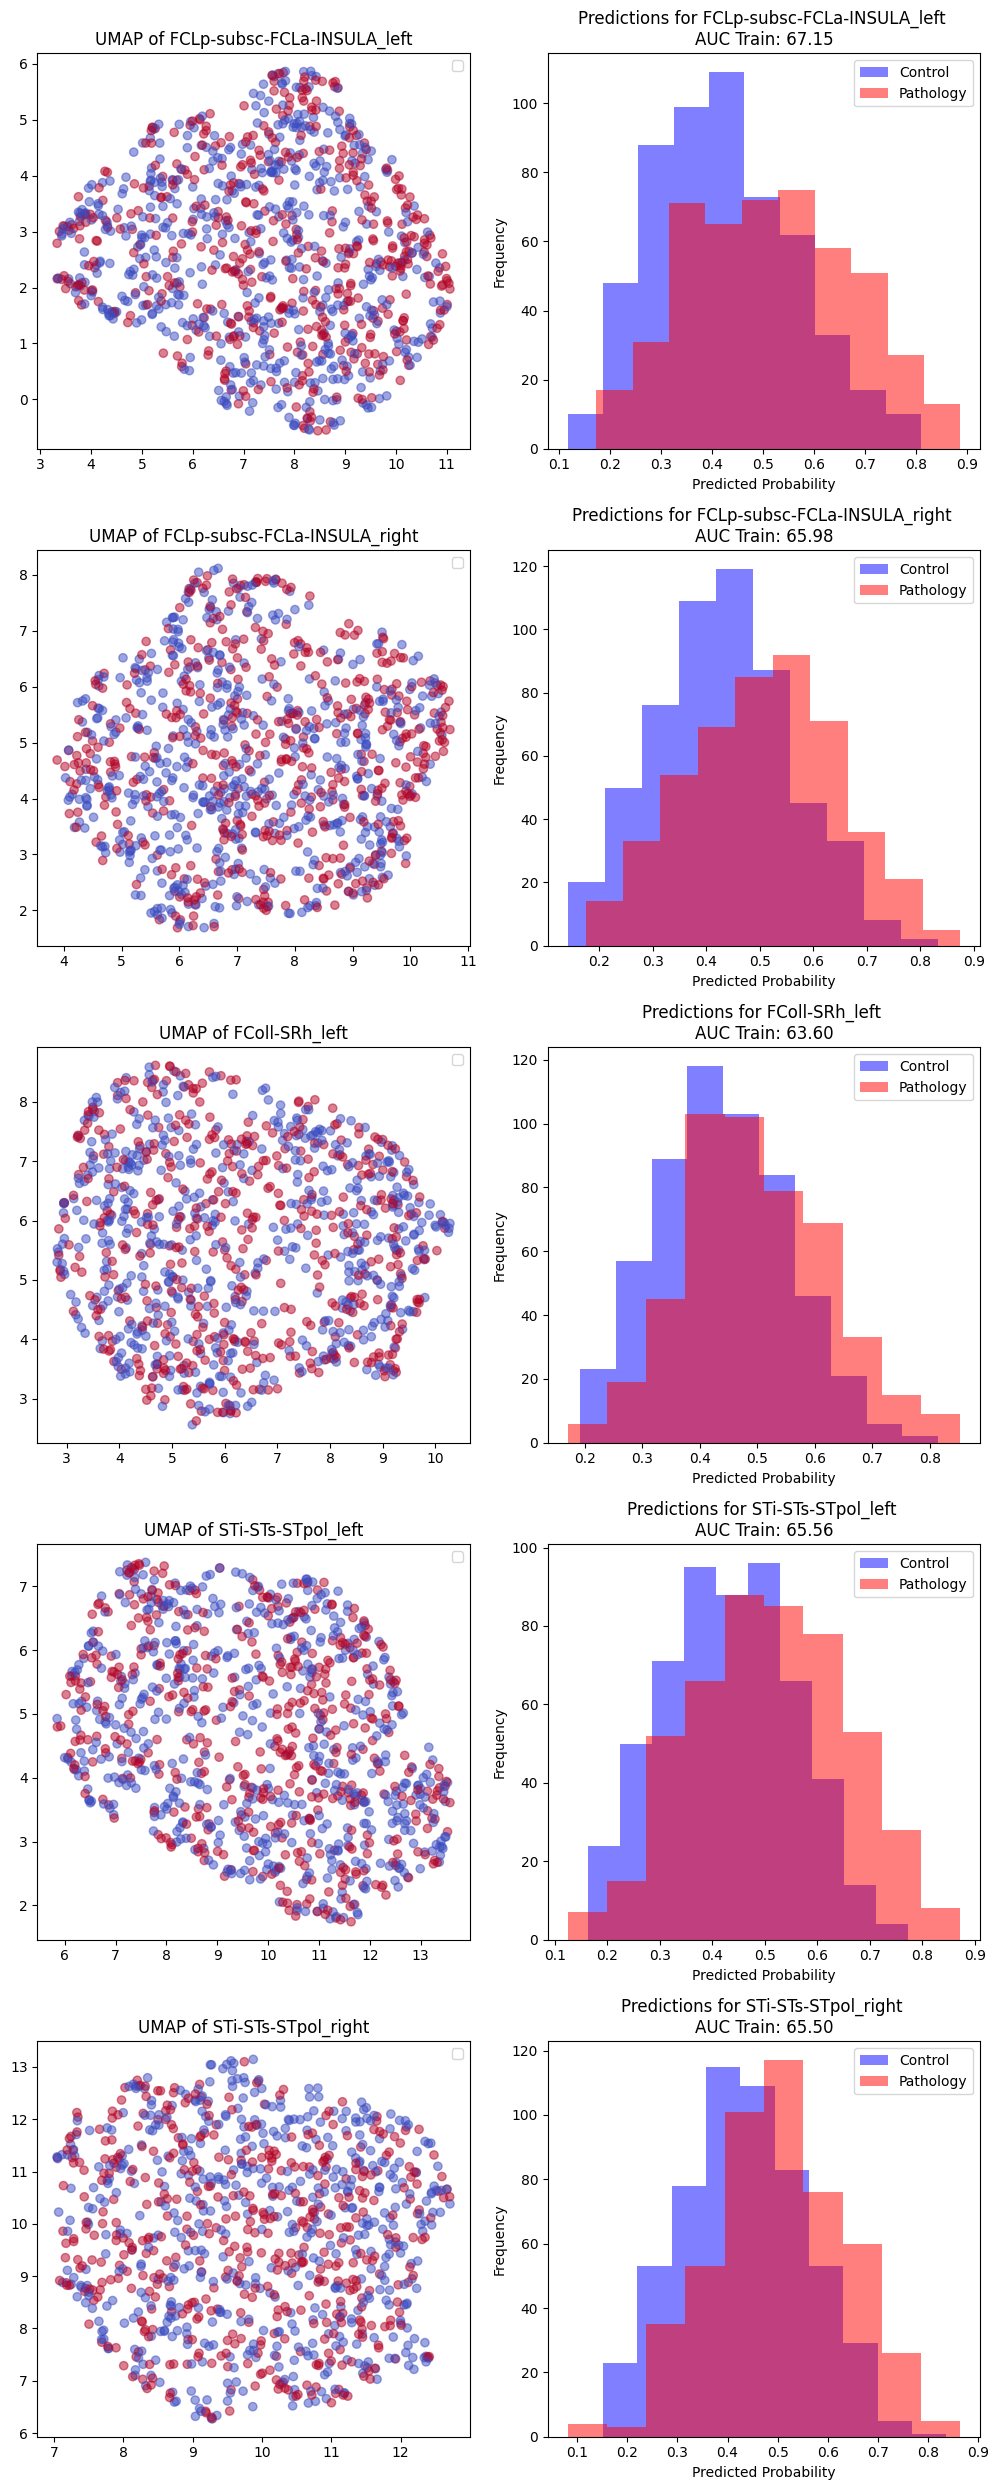

In [20]:
sex_residualization = True
site_residualization = True
method = 'LogisticRegression'

fig, axs = plt.subplots(nrows=len(best_regions), ncols=2, figsize=(10, 5*len(best_regions)))

for i, directory in enumerate(directories):
        ax1, ax2 = axs[i, 0], axs[i, 1]
        region = directory.split('/')[-4]
        print(f'Treating {region}')
        embd=pd.read_csv(directory)
        embd=pd.merge(embd, df_all, on='ID')
        
        # fit standard scaler on embd and transform
        std = StandardScaler()
        embd_matrix = embd.loc[:, embd.columns.str.startswith('dim')]
        std_embds = std.fit_transform(embd_matrix)
        embd.loc[:, embd.columns.str.startswith('dim')] = std_embds
        print('Length embeddings : ', embd.shape[0])

        if sex_residualization and not site_residualization:
            # residualize X regarding sex
            sex = embd['sex']
            resid_var = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = pd.DataFrame(resid_var)
        
        if site_residualization and not sex_residualization:
            # Get dummy variables for the categorical variable
            resid_var = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
        
        if site_residualization and sex_residualization:
            # Get dummy variables for the categorical variable
            group_dummies = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
            # add sex
            sex = embd['sex']
            sex = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = pd.concat((group_dummies, sex), axis=1)
        
        if site_residualization or sex_residualization:
            ## residualize each latent variable
            for dim_i in [f'dim{j}' for j in range(1,n_dims+1)]:
                # select control subjects only to perform residualization
                y = embd[dim_i]
                y_control = embd.loc[embd['diagnosis']=='control'][dim_i]
                resid_var_control = resid_var.loc[embd['diagnosis']=='control']
                merged_df = pd.merge(pd.DataFrame(y_control), resid_var_control, left_index=True, right_index=True)
                formula = f"{dim_i} ~ " + ' + '.join([f'C({variable})' for variable in resid_var]) + ' + const'
                merged_df = sm.add_constant(merged_df)
                results = sm.formula.ols(formula=formula, data=merged_df).fit()
                resid_var = sm.add_constant(resid_var)
                y_pred_all = results.predict(resid_var)
                y_resid_all = y - y_pred_all
                embd.loc[:, dim_i] = y_resid_all

        X = embd.loc[:, embd.columns.str.startswith('dim')]
        Y = embd.loc[:, label]
        # assign value 1 to asd and 0 to control
        Y = Y.apply(lambda x: 0 if x == 'control' else 1)

        # # Add intercept
        X_const = sm.add_constant(X)
        # Perform UMAP
        umap_embedding = umap_reducer.fit_transform(X_const)
        # plot UMAP with labels
        ax1.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=Y.tolist(), alpha=0.5, cmap='coolwarm')
        ax1.set_title(f'UMAP of {region}')
        ax1.legend()

        # Fit the full model
        model_full = sm.Logit(Y, X_const)
        result_full = model_full.fit()
        df_preds = pd.merge(pd.DataFrame(embd['ID']), pd.DataFrame(result_full.predict(X_const), columns=['prediction']), left_index=True, right_index=True)
        df_preds = df_preds.merge(df_all[['ID', 'diagnosis']], on='ID', how='left')
        # compute roc auc
        roc_auc = roc_auc_score(df_preds['diagnosis']!='control', df_preds['prediction'])

        # plot predictions compared to labels
        ax2.hist(df_preds.loc[df_preds['diagnosis']=='control']['prediction'], alpha=0.5, label='Control', color='blue')
        ax2.hist(df_preds.loc[df_preds['diagnosis']!='control']['prediction'], alpha=0.5, label='Pathology', color='red')
        ax2.set_title(f'Predictions for {region} \nAUC Train: {100 * roc_auc:.2f}')
        ax2.set_xlabel('Predicted Probability')
        ax2.set_ylabel('Frequency')
        ax2.legend()

plt.tight_layout()
plt.show()

# Apply unsupervised clustering method and report the proportion of each class in each cluster

traditionnal clustering methods can't find clusters

In [151]:
from sklearn.cluster import HDBSCAN
hdb = HDBSCAN(min_cluster_size=10, leaf_size=10, metric='manhattan')

Treating FCLp-subsc-FCLa-INSULA_left
Length embeddings :  1029
Treating FCLp-subsc-FCLa-INSULA_right
Length embeddings :  1029
Treating FColl-SRh_left
Length embeddings :  1029
Treating STi-STs-STpol_left
Length embeddings :  1029
Treating STi-STs-STpol_right
Length embeddings :  1029


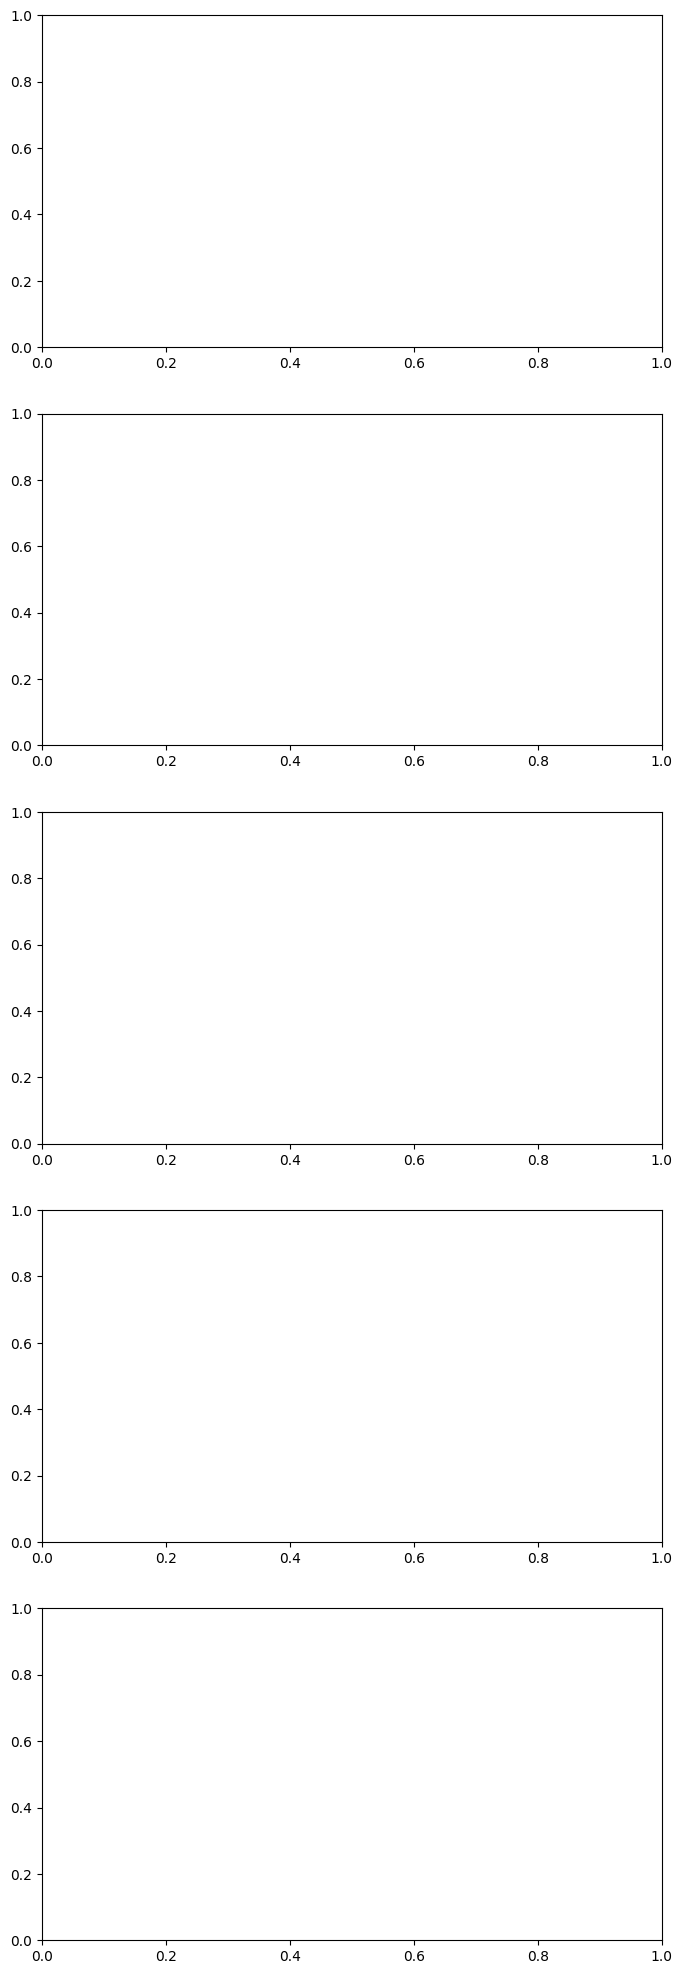

In [156]:
#fig, axs = plt.subplots(nrows=len(best_regions), ncols=1, figsize=(8, 5*len(best_regions)))

for i, directory in enumerate(directories):
        #ax = axs[i]
        region = directory.split('/')[-4]
        print(f'Treating {region}')
        embd=pd.read_csv(directory)
        embd=pd.merge(embd, df_all, on='ID')
        
        # fit standard scaler on embd and transform
        std = StandardScaler()
        embd_matrix = embd.loc[:, embd.columns.str.startswith('dim')]
        std_embds = std.fit_transform(embd_matrix)
        embd.loc[:, embd.columns.str.startswith('dim')] = std_embds
        print('Length embeddings : ', embd.shape[0])

        if sex_residualization and not site_residualization:
            # residualize X regarding sex
            sex = embd['sex']
            resid_var = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = pd.DataFrame(resid_var)
        
        if site_residualization and not sex_residualization:
            # Get dummy variables for the categorical variable
            resid_var = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
        
        if site_residualization and sex_residualization:
            # Get dummy variables for the categorical variable
            group_dummies = pd.get_dummies(embd['site'], drop_first=False, dtype='float')
            # add sex
            sex = embd['sex']
            sex = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = pd.concat((group_dummies, sex), axis=1)
        
        if site_residualization or sex_residualization:
            ## residualize each latent variable
            for dim_i in [f'dim{j}' for j in range(1,n_dims+1)]:
                # select control subjects only to perform residualization
                y = embd[dim_i]
                y_control = embd.loc[embd['diagnosis']=='control'][dim_i]
                resid_var_control = resid_var.loc[embd['diagnosis']=='control']
                merged_df = pd.merge(pd.DataFrame(y_control), resid_var_control, left_index=True, right_index=True)
                formula = f"{dim_i} ~ " + ' + '.join([f'C({variable})' for variable in resid_var]) + ' + const'
                merged_df = sm.add_constant(merged_df)
                results = sm.formula.ols(formula=formula, data=merged_df).fit()
                resid_var = sm.add_constant(resid_var)
                y_pred_all = results.predict(resid_var)
                y_resid_all = y - y_pred_all
                embd.loc[:, dim_i] = y_resid_all

        X = embd.loc[:, embd.columns.str.startswith('dim')]
        Y = embd.loc[:, label]
        # assign value 1 to asd and 0 to control
        Y = Y.apply(lambda x: 0 if x == 'control' else 1)

        ## save embeddings
        X.to_csv(os.path.join('/neurospin/dico/jlaval/Runs_jl277509/Gauging-delta/datasets', f'{region}_schiz_embeddings.txt'), index=False, header=None, sep=',')

        # Apply clustering on X
        # hdb.fit(X)
        # cluster_labels = hdb.labels_.tolist()
        # df_clusters = pd.DataFrame({'ID': embd['ID'], 'cluster': cluster_labels, 'labels': Y})

        # # plot clusters distribution in terms of labels
        # cluster_counts = df_clusters.groupby(['cluster', 'labels']).size().unstack(fill_value=0)
        # cluster_counts.plot(kind='bar', stacked=True, ax=ax)

#plt.show()


(array([121, 190, 285, 312, 425, 448, 453, 506, 526, 744, 774, 785, 956,
        999]),
 array([ 71, 113,  65,  42,  59, 104,  60, 160,  31,  10, 150,  52,  83,
         29]))

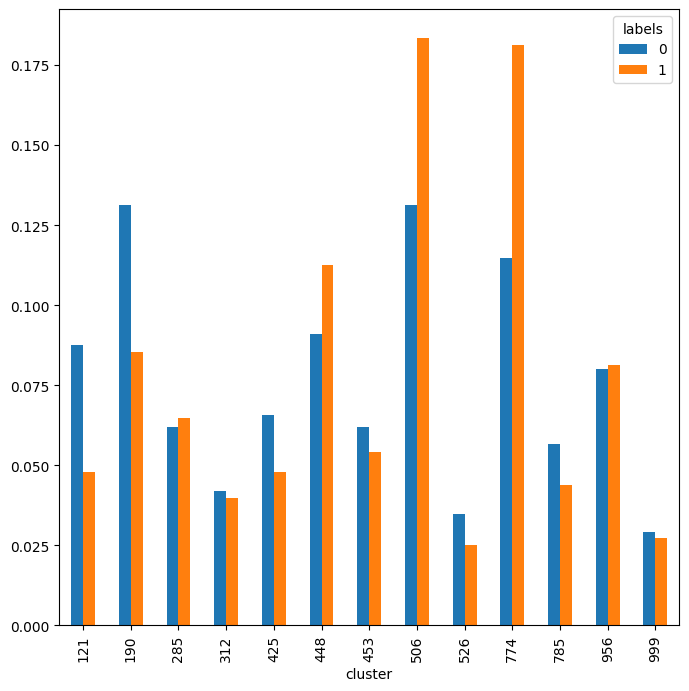

In [90]:
reg = 'FCLp-subsc-FCLa-INSULA_left'
n_min = 30

# test Gauging-Delta (cosine ish)
cluster_labels = pd.read_csv(f'/neurospin/dico/jlaval/Runs_jl277509/Gauging-delta/results/labels/latent_schiz_{reg}.txt', header=None)
np.unique(cluster_labels, return_counts=True)

# plot distribution of each cluster label compared to labels

df_clusters = pd.DataFrame({'ID': embd['ID'], 'cluster': cluster_labels[0], 'labels': Y})
# plot clusters distribution in terms of labels
fig, ax = plt.subplots(figsize=(8, 8))
cluster_counts = df_clusters.groupby(['cluster', 'labels']).size().unstack(fill_value=0)
# normalize each distribution to account for label imbalance
cluster_frequency = cluster_counts.copy()
cluster_frequency[0] = cluster_counts[0] / np.sum(cluster_counts[0])
cluster_frequency[1] = cluster_counts[1] / np.sum(cluster_counts[1])
# ignore small clusters
cluster_frequency = cluster_frequency[cluster_frequency.sum(axis=1) > n_min / len(Y)]  # Keep clusters with more than 10 samples
cluster_frequency.plot(kind='bar', stacked=False, ax=ax)
plt.show()

In [91]:
# for each, cluster, does it follow a binomial law with p=0.5 ? p-value on that null hypothesis ?

## define control proba for statistical test
prop_control = len(df_clusters.loc[df_clusters['labels']==0]) / len(df_clusters)

## remove small clusters
cluster_counts = cluster_counts[cluster_counts.sum(axis=1) > n_min]

from scipy.stats import binomtest
p_values = []
for cluster in cluster_counts.index:
    count_control = cluster_counts.loc[cluster, 0]
    count_pathology = cluster_counts.loc[cluster, 1]
    total_count = count_control + count_pathology
    if total_count > 0:
        p_value = binomtest(count_control, n=total_count, p=prop_control, alternative='two-sided')
        p_values.append((cluster, total_count, p_value.pvalue))

    else:
        p_values.append((cluster, np.nan))

p_values_df = pd.DataFrame(p_values, columns=['cluster', 'cluster_size', 'p_value'])
p_values_df.sort_values(by='p_value', ascending=True, inplace=True)

In [92]:
p_values_df

,cluster,cluster_size,p_value
9,774,150,0.006725
0,121,71,0.017131
1,190,113,0.029875
7,506,160,0.039106
4,425,59,0.243943
5,448,104,0.281844
10,785,52,0.405867
8,526,31,0.472236
6,453,60,0.698248
3,312,42,0.878449


In [ ]:
np.sum(np.square(cluster_counts[0] - cluster_counts[1]) / (cluster_counts[0] + cluster_counts[1]))  # the statistic ? but doesn't take into account p_control !

31.156502103401625

In [93]:
# or use chi2 test to test global p-value of clustering
from scipy.stats import chi2_contingency
chi2_results = chi2_contingency(cluster_counts.values)
chi2_statistic = chi2_results[0]
chi2_p_value = chi2_results[1]
print(f'Chi2 statistic: {chi2_statistic}, Chi2 p-value: {chi2_p_value}')

Chi2 statistic: 27.38106368774577, Chi2 p-value: 0.0040233776103712066


In [102]:
# try agglomerative clustering
region = 'STi-STs-STpol_right'

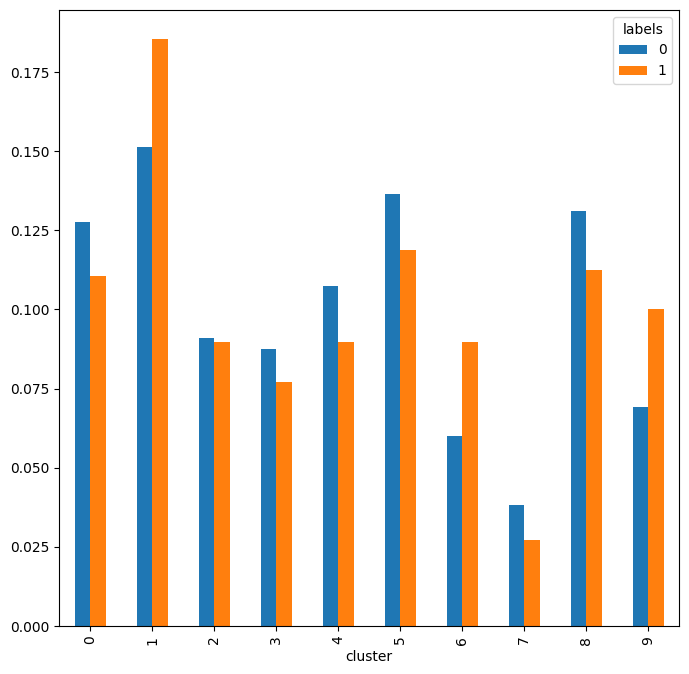

In [103]:

from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=10, linkage='ward')
agglo.fit(X.to_numpy())
# get cluster labels
cluster_labels = agglo.labels_
# create dataframe with cluster labels and labels
df_clusters = pd.DataFrame({'ID': embd['ID'], 'cluster': cluster_labels, 'labels': Y})

fig, ax = plt.subplots(figsize=(8, 8))
cluster_counts = df_clusters.groupby(['cluster', 'labels']).size().unstack(fill_value=0)
# normalize each distribution to account for label imbalance
cluster_frequency = cluster_counts.copy()
cluster_frequency[0] = cluster_counts[0] / np.sum(cluster_counts[0])
cluster_frequency[1] = cluster_counts[1] / np.sum(cluster_counts[1])
# ignore small clusters
cluster_frequency = cluster_frequency[cluster_frequency.sum(axis=1) > n_min / len(Y)]  # Keep clusters with more than 10 samples
cluster_frequency.plot(kind='bar', stacked=False, ax=ax)
plt.show()

In [104]:
# for each, cluster, does it follow a binomial law with p=0.5 ? p-value on that null hypothesis ?

## define control proba for statistical test
prop_control = len(df_clusters.loc[df_clusters['labels']==0]) / len(df_clusters)

## remove small clusters
cluster_counts = cluster_counts[cluster_counts.sum(axis=1) > n_min]

from scipy.stats import binomtest
p_values = []
for cluster in cluster_counts.index:
    count_control = cluster_counts.loc[cluster, 0]
    count_pathology = cluster_counts.loc[cluster, 1]
    total_count = count_control + count_pathology
    if total_count > 0:
        p_value = binomtest(count_control, n=total_count, p=prop_control, alternative='two-sided')
        p_values.append((cluster, total_count, p_value.pvalue))

    else:
        p_values.append((cluster, np.nan))

p_values_df = pd.DataFrame(p_values, columns=['cluster', 'cluster_size', 'p_value'])
p_values_df.sort_values(by='p_value', ascending=True, inplace=True)

In [105]:
p_values_df

,cluster,cluster_size,p_value
6,6,76,0.085619
9,9,86,0.104533
1,1,172,0.193984
4,4,102,0.373712
7,7,34,0.391197
8,8,126,0.422203
5,5,132,0.433922
0,0,123,0.470011
3,3,85,0.588278
2,2,93,1.000000


In [106]:
# or use chi2 test to test global p-value of clustering
from scipy.stats import chi2_contingency
chi2_results = chi2_contingency(cluster_counts.values)
chi2_statistic = chi2_results[0]
chi2_p_value = chi2_results[1]
print(f'Chi2 statistic: {chi2_statistic}, Chi2 p-value: {chi2_p_value}')

Chi2 statistic: 11.832399362228939, Chi2 p-value: 0.22292360912132542


# restrict to n regions for global classification

In [111]:
## select best regions to perform classification (add sts right, because its symmetric)
#best_regions = ['FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'STi-STs-STpol_left', 'STi-STs-STpol_right', 'FColl-SRh_left'] ## case obtains with 1000 subs
best_regions = ['FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'STi_STs_STpol_left', 'FColl-SRh_left'] ## with 800 subs, STi-STs-STpol shouldn't be kept !!

In [623]:
from group_lasso import LogisticGroupLasso
best_regions = regions_to_treat.copy()
best_regions.remove('LARGE_CINGULATE_left')
best_regions.remove('LARGE_CINGULATE_right')
best_regions.remove('fronto-parietal_medial_face_left')
best_regions.remove('fronto-parietal_medial_face_right')
best_regions.remove('Lobule_parietal_sup_left')
best_regions.remove('Lobule_parietal_sup_right')
#best_regions.remove('FColl-SRh_left') # best region
#best_regions.remove('SFmedian-SFpoltr-SFsup_left') # best region when removing both FColl-SRh : site effect captured ?
len(best_regions)

50

In [624]:
## load and concat embeddings, and evaluate on test
embd_list = []
for i, directory in enumerate(tqdm(dfs_dirs)):
    region = directory.split('/')[-4]
    if region in best_regions:
        print(f'Treating {region}')
        embd=pd.read_csv(directory)
        embd=pd.merge(embd, df_all, on='ID')
        
        # fit standard scaler on embd and transform
        std = StandardScaler()
        embd_matrix = embd.loc[:, embd.columns.str.startswith('dim')]
        std_embds = std.fit_transform(embd_matrix)
        embd.loc[:, embd.columns.str.startswith('dim')] = std_embds
        print('Length embeddings : ', embd.shape[0])
        if sex_residualization and not site_residualization:
        # residualize X regarding sex
            sex = embd['sex']
            resid_var = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = pd.DataFrame(resid_var)

        if site_residualization and not sex_residualization:
            # Get dummy variables for the categorical variable
            resid_var = pd.get_dummies(embd['site'], drop_first=True, dtype='float')

        if site_residualization and sex_residualization:
            # Get dummy variables for the categorical variable
            group_dummies = pd.get_dummies(embd['site'], drop_first=True, dtype='float')
            # add sex
            sex = embd['sex']
            sex = sex.apply(lambda x: 1 if x == 'M' else 0)
            resid_var = pd.concat((group_dummies, sex), axis=1)

        if site_residualization or sex_residualization:
            ## residualize each latent variable
            for dim_i in [f'dim{j}' for j in range(1,n_dims+1)]:
                # select control subjects only to perform residualization
                y = embd[dim_i]
                y_control = embd.loc[embd['diagnosis']=='control'][dim_i]
                resid_var_control = resid_var.loc[embd['diagnosis']=='control']
                merged_df = pd.merge(pd.DataFrame(y_control), resid_var_control, left_index=True, right_index=True)
                formula = f"{dim_i} ~ " + ' + '.join([f'C({variable})' for variable in resid_var]) + ' + const'
                merged_df = sm.add_constant(merged_df)
                results = sm.formula.ols(formula=formula, data=merged_df).fit()
                resid_var = sm.add_constant(resid_var)
                y_pred_all = results.predict(resid_var)
                y_resid_all = y - y_pred_all
                embd.loc[:, dim_i] = y_resid_all

        embd_list.append(embd)

  0%|          | 0/56 [00:00<?, ?it/s]

Treating CINGULATE_left
Length embeddings :  1029


  2%|▏         | 1/56 [00:02<01:56,  2.11s/it]

Treating CINGULATE_right
Length embeddings :  1029


  4%|▎         | 2/56 [00:04<01:51,  2.07s/it]

Treating FCLp-subsc-FCLa-INSULA_left
Length embeddings :  1029


  5%|▌         | 3/56 [00:06<01:46,  2.00s/it]

Treating FCLp-subsc-FCLa-INSULA_right
Length embeddings :  1029


  7%|▋         | 4/56 [00:08<01:42,  1.97s/it]

Treating FCMpost-SpC_left
Length embeddings :  1029


  9%|▉         | 5/56 [00:10<01:41,  1.99s/it]

Treating FCMpost-SpC_right
Length embeddings :  1029


 11%|█         | 6/56 [00:12<01:39,  1.99s/it]

Treating FColl-SRh_right
Length embeddings :  1029


 14%|█▍        | 8/56 [00:13<01:11,  1.49s/it]

Treating FIP_left
Length embeddings :  1029


 16%|█▌        | 9/56 [00:15<01:15,  1.61s/it]

Treating FIP_right
Length embeddings :  1029


 18%|█▊        | 10/56 [00:17<01:17,  1.70s/it]

Treating FPO-SCu-ScCal_left
Length embeddings :  1029


 20%|█▉        | 11/56 [00:19<01:19,  1.77s/it]

Treating FPO-SCu-ScCal_right
Length embeddings :  1029


 21%|██▏       | 12/56 [00:21<01:19,  1.80s/it]

Treating OCCIPITAL_left
Length embeddings :  1029


 27%|██▋       | 15/56 [00:23<00:47,  1.15s/it]

Treating OCCIPITAL_right
Length embeddings :  1029


 29%|██▊       | 16/56 [00:25<00:51,  1.30s/it]

Treating SC-SPeC_left
Length embeddings :  1029


 30%|███       | 17/56 [00:27<00:55,  1.42s/it]

Treating SC-SPeC_right
Length embeddings :  1029


 32%|███▏      | 18/56 [00:29<00:57,  1.52s/it]

Treating SC-SPoC_left
Length embeddings :  1029


 34%|███▍      | 19/56 [00:30<00:59,  1.61s/it]

Treating SC-SPoC_right
Length embeddings :  1029


 36%|███▌      | 20/56 [00:32<00:59,  1.66s/it]

Treating SC-sylv_left
Length embeddings :  1029


 38%|███▊      | 21/56 [00:34<01:00,  1.72s/it]

Treating SC-sylv_right
Length embeddings :  1029


 39%|███▉      | 22/56 [00:36<00:59,  1.76s/it]

Treating SFinf-BROCA-SPeCinf_left
Length embeddings :  1029


 41%|████      | 23/56 [00:38<00:58,  1.78s/it]

Treating SFinf-BROCA-SPeCinf_right
Length embeddings :  1029


 43%|████▎     | 24/56 [00:40<00:57,  1.80s/it]

Treating SFint-FCMant_left
Length embeddings :  1029


 45%|████▍     | 25/56 [00:42<00:56,  1.83s/it]

Treating SFint-FCMant_right
Length embeddings :  1029


 46%|████▋     | 26/56 [00:43<00:54,  1.83s/it]

Treating SFint-SR_left
Length embeddings :  1029


 48%|████▊     | 27/56 [00:45<00:53,  1.83s/it]

Treating SFint-SR_right
Length embeddings :  1029


 50%|█████     | 28/56 [00:47<00:52,  1.86s/it]

Treating SFinter-SFsup_left
Length embeddings :  1029


 52%|█████▏    | 29/56 [00:49<00:50,  1.86s/it]

Treating SFinter-SFsup_right
Length embeddings :  1029


 54%|█████▎    | 30/56 [00:51<00:47,  1.84s/it]

Treating SFmarginal-SFinfant_left
Length embeddings :  1029


 55%|█████▌    | 31/56 [00:53<00:46,  1.87s/it]

Treating SFmarginal-SFinfant_right
Length embeddings :  1029


 57%|█████▋    | 32/56 [00:55<00:44,  1.86s/it]

Treating SFmedian-SFpoltr-SFsup_right
Length embeddings :  1029


 61%|██████    | 34/56 [00:56<00:31,  1.43s/it]

Treating SOr-SOlf_left
Length embeddings :  1029


 62%|██████▎   | 35/56 [00:58<00:32,  1.56s/it]

Treating SOr-SOlf_right
Length embeddings :  1029


 64%|██████▍   | 36/56 [01:00<00:32,  1.64s/it]

Treating SOr_left
Length embeddings :  1029


 66%|██████▌   | 37/56 [01:02<00:32,  1.71s/it]

Treating SOr_right
Length embeddings :  1029


 68%|██████▊   | 38/56 [01:04<00:31,  1.75s/it]

Treating SPeC_left
Length embeddings :  1029


 70%|██████▉   | 39/56 [01:06<00:30,  1.77s/it]

Treating SPeC_right
Length embeddings :  1029


 71%|███████▏  | 40/56 [01:08<00:28,  1.80s/it]

Treating SPoC_left
Length embeddings :  1029


 73%|███████▎  | 41/56 [01:10<00:29,  1.98s/it]

Treating SPoC_right
Length embeddings :  1029


 75%|███████▌  | 42/56 [01:12<00:28,  2.01s/it]

Treating STi-SOTlat_left
Length embeddings :  1029


 77%|███████▋  | 43/56 [01:14<00:25,  1.97s/it]

Treating STi-SOTlat_right
Length embeddings :  1029


 79%|███████▊  | 44/56 [01:16<00:23,  1.93s/it]

Treating STi-STs-STpol_left
Length embeddings :  1029


 80%|████████  | 45/56 [01:18<00:21,  1.91s/it]

Treating STi-STs-STpol_right
Length embeddings :  1029


 82%|████████▏ | 46/56 [01:20<00:18,  1.89s/it]

Treating STs_left
Length embeddings :  1029


 84%|████████▍ | 47/56 [01:21<00:16,  1.88s/it]

Treating STs_right
Length embeddings :  1029


 86%|████████▌ | 48/56 [01:23<00:14,  1.87s/it]

Treating STsbr_left
Length embeddings :  1029


 88%|████████▊ | 49/56 [01:25<00:13,  1.86s/it]

Treating STsbr_right
Length embeddings :  1029


 89%|████████▉ | 50/56 [01:27<00:11,  1.88s/it]

Treating ScCal-SLi_left
Length embeddings :  1029


 91%|█████████ | 51/56 [01:29<00:09,  1.87s/it]

Treating ScCal-SLi_right
Length embeddings :  1029


 93%|█████████▎| 52/56 [01:31<00:07,  1.86s/it]

Treating SsP-SPaint_left
Length embeddings :  1029


 95%|█████████▍| 53/56 [01:33<00:05,  1.86s/it]

Treating SsP-SPaint_right
Length embeddings :  1029


100%|██████████| 56/56 [01:34<00:00,  1.69s/it]


In [625]:
embds_glob = pd.concat(
    [df.add_suffix(f'_{i}') for i, df in enumerate(embd_list)],
    axis=1
)

In [626]:
embds_glob_test = embds_glob.loc[embds_glob['ID_train_val_test_0'].isin(results_stratif[0]['ID_train_val_test'])]
X_test, Y_test = embds_glob_test.loc[:, embds_glob_test.columns.str.startswith('dim')], embds_glob_test['diagnosis_0']
Y_test = np.array([elem!='control' for elem in Y_test])
print(X_test.shape, Y_test.shape)

(206, 1600) (206,)


In [627]:
embds_glob_train = embds_glob.loc[embds_glob['ID_train_val_test_0'].isin(pd.concat(results_stratif[k]['ID_train_val_test'] for k in range(1,5)))]
X_train, Y_train = embds_glob_train.loc[:, embds_glob_train.columns.str.startswith('dim')], embds_glob_train['diagnosis_0']
Y_train = np.array([elem!='control' for elem in Y_train])
print(X_train.shape, Y_train.shape)
# create groups for cv
groups_df = pd.concat([results_stratif[k][['ID_train_val_test']].assign(source=k) for k in range(1,5)])
groups_df.columns = ['ID_train_val_test_0', 'source']
groups_df = embds_glob_train.merge(groups_df)[['ID_train_val_test_0', 'source']]
# reorder the same as embds_glob_train
groups = groups_df['source']
logo = LeaveOneGroupOut()
cv = [*(logo.split(X_train, Y_train, groups=groups))]

(823, 1600) (823,)


In [628]:
# gridsearch cv
#model = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=100)
#param_grid = {
#    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#    'l1_ratio': [0., 0.2, 0.4, 0.6, 0.8, 1.],
#}

In [629]:
# group lasso
groups_lasso = [k//n_dims for k in range(n_dims*len(best_regions))]  # Create groups for each region

model = LogisticGroupLasso(
    groups=groups_lasso,
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=100,
)

param_grid = {'group_reg' : np.linspace(0,1,21), ## [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
              'l1_reg' : np.array([0.15]) / n_dims,
              'scale_reg' : ['inverse_group_size'],
              'subsampling_scheme' : [1]}
## With 0.2 : 32 regions
## With 0.5 : 7 regions
## With 0.6 : 5 regions
# The gridsearch selects many regions, but we can choose to restrict to N regions maximum to avoid later overfitting
## Q : how to select N ? Use also the standard deviation of the cross validation instead of the mean ?? To prevent further overfitting.
# 0.2 > 0.5 > 0.1 : but 0.5 has better generelization performance

/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


In [630]:
clf = GridSearchCV(model, param_grid, cv=cv, refit=False, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, Y_train)

/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing 

GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  16,  18,  19,  20,  21,  24,  26,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  39,  40,  41,  42,  43,  45,  46,  47,
        48,  49,  51,  52,  53,  54,  56,  57,  58,  60,  61,  62,  63,
        64,  66,  67,  68,  69,  71,  73,  77,  78,  79,  80,  83,  85,
        86,  88,  90,  91,  93,  94,  96,  97,  98,  99, 100, 102, 103,
       104, 105, 106, 107, 108, 109, 111, 112, 113, 116, 118, 119, 120,
       122, 123, 125, 126, 128, 129, 130, 131, 132, 133, 134, 13...
             estimator=LogisticGroupLasso(groups=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                  0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...],
                                          subsampling_scheme=1,
                                          supress_warning=True),
             n_jobs=-1,
             param_grid={'group_reg': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'l1_reg': array([0.0046875]),
                         'scale_reg': ['inverse_group_size'],
                         'subsampling_scheme': [1]},
             refit=False, scoring='roc_auc')

In [631]:
best_params = clf.best_params_
print(f'Best parameters: {best_params}')
print(f'Best score: {clf.best_score_}')

Best parameters: {'group_reg': np.float64(0.1), 'l1_reg': np.float64(0.0046875), 'scale_reg': 'inverse_group_size', 'subsampling_scheme': 1}
Best score: 0.6416999335453335


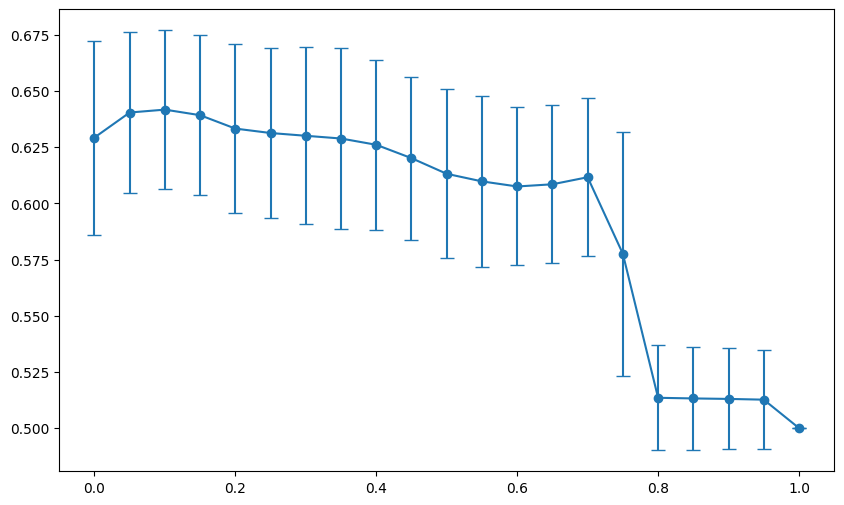

In [632]:
# plot results_df :
import matplotlib.pyplot as plt
results_df = pd.DataFrame(clf.cv_results_)

param = results_df['param_group_reg']
score = results_df['mean_test_score']
std = results_df['std_test_score']
plt.figure(figsize=(10, 6))
plt.errorbar(param, score, yerr=std, fmt='o-', capsize=5)
plt.show()

In [229]:
#model = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=100, C=clf.best_params_['C'], l1_ratio=clf.best_params_['l1_ratio'])
#model.fit(X_train, Y_train)

KeyError: 'C'

In [633]:
## loop on the group_reg param to get number of regions selected
n_selected_regions = []
list_selected_regions = []

for group_reg in np.linspace(0,1,21):

    model = LogisticGroupLasso(
        groups=groups_lasso,
        group_reg=group_reg,
        l1_reg=clf.best_params_['l1_reg'],
        scale_reg='inverse_group_size',
        subsampling_scheme=1,
        supress_warning=True,
    )

    model.fit(X_train, Y_train)

    ## for group lasso
    sparsity_mask = model.sparsity_mask_
    print(f"Number of chosen variables: {sparsity_mask.sum()}, out of {len(sparsity_mask)}")
    ## selected regions
    ## convolve sparsity mask to get regions
    from scipy.ndimage import convolve1d
    selected_regions = [np.sum(sparsity_mask[i:i+n_dims]) for i in range(0, len(sparsity_mask), n_dims)]
    selected_regions = [best_regions[i] for i, val in enumerate(selected_regions) if val > 0]
    print('Number of selected regions:', len(selected_regions))
    print(selected_regions)
    n_selected_regions.append(len(selected_regions))
    list_selected_regions.append(selected_regions)

/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 231, out of 1600
Number of selected regions: 49
['SOr_left', 'SOr_right', 'SFinf-BROCA-SPeCinf_left', 'SPoC_left', 'FIP_left', 'CINGULATE_left', 'SC-SPoC_left', 'SFinter-SFsup_left', 'FCMpost-SpC_left', 'SsP-SPaint_left', 'SOr-SOlf_left', 'FPO-SCu-ScCal_left', 'SFmarginal-SFinfant_left', 'SFint-FCMant_left', 'SFint-SR_left', 'STi-SOTlat_left', 'SPeC_left', 'STsbr_left', 'ScCal-SLi_left', 'STs_left', 'FCLp-subsc-FCLa-INSULA_left', 'SC-sylv_left', 'SC-SPeC_left', 'OCCIPITAL_left', 'FColl-SRh_right', 'SFmedian-SFpoltr-SFsup_right', 'SFinf-BROCA-SPeCinf_right', 'SPoC_right', 'FIP_right', 'CINGULATE_right', 'SC-SPoC_right', 'SFinter-SFsup_right', 'FCMpost-SpC_right', 'SsP-SPaint_right', 'SOr-SOlf_right', 'FPO-SCu-ScCal_right', 'SFmarginal-SFinfant_right', 'SFint-FCMant_right', 'STi-STs-STpol_right', 'SFint-SR_right', 'STi-SOTlat_right', 'SPeC_right', 'STsbr_right', 'ScCal-SLi_right', 'STs_right', 'FCLp-subsc-FCLa-INSULA_right', 'SC-sylv_right', 'SC-SPeC_right', '

/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 368, out of 1600
Number of selected regions: 39
['SOr_left', 'SOr_right', 'SFinf-BROCA-SPeCinf_left', 'FIP_left', 'CINGULATE_left', 'SC-SPoC_left', 'SFinter-SFsup_left', 'FCMpost-SpC_left', 'SOr-SOlf_left', 'FPO-SCu-ScCal_left', 'SFmarginal-SFinfant_left', 'SPeC_left', 'STsbr_left', 'ScCal-SLi_left', 'STs_left', 'FCLp-subsc-FCLa-INSULA_left', 'SC-sylv_left', 'OCCIPITAL_left', 'FColl-SRh_right', 'SFmedian-SFpoltr-SFsup_right', 'SFinf-BROCA-SPeCinf_right', 'SPoC_right', 'FIP_right', 'CINGULATE_right', 'SC-SPoC_right', 'SFinter-SFsup_right', 'SsP-SPaint_right', 'FPO-SCu-ScCal_right', 'SFmarginal-SFinfant_right', 'SFint-FCMant_right', 'STi-STs-STpol_right', 'STi-SOTlat_right', 'SPeC_right', 'ScCal-SLi_right', 'STs_right', 'FCLp-subsc-FCLa-INSULA_right', 'SC-sylv_right', 'SC-SPeC_right', 'OCCIPITAL_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 415, out of 1600
Number of selected regions: 33
['SOr_left', 'SOr_right', 'SFinf-BROCA-SPeCinf_left', 'FIP_left', 'CINGULATE_left', 'SC-SPoC_left', 'SFinter-SFsup_left', 'FCMpost-SpC_left', 'SOr-SOlf_left', 'FPO-SCu-ScCal_left', 'SPeC_left', 'STsbr_left', 'ScCal-SLi_left', 'SC-sylv_left', 'OCCIPITAL_left', 'FColl-SRh_right', 'SFmedian-SFpoltr-SFsup_right', 'SFinf-BROCA-SPeCinf_right', 'SPoC_right', 'FIP_right', 'SC-SPoC_right', 'SFinter-SFsup_right', 'FPO-SCu-ScCal_right', 'SFmarginal-SFinfant_right', 'SFint-FCMant_right', 'STi-STs-STpol_right', 'STi-SOTlat_right', 'SPeC_right', 'STs_right', 'FCLp-subsc-FCLa-INSULA_right', 'SC-sylv_right', 'SC-SPeC_right', 'OCCIPITAL_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 364, out of 1600
Number of selected regions: 26
['SOr_left', 'SOr_right', 'SFinf-BROCA-SPeCinf_left', 'FIP_left', 'SC-SPoC_left', 'SFinter-SFsup_left', 'FCMpost-SpC_left', 'FPO-SCu-ScCal_left', 'SPeC_left', 'STsbr_left', 'ScCal-SLi_left', 'SC-sylv_left', 'OCCIPITAL_left', 'SFinf-BROCA-SPeCinf_right', 'SPoC_right', 'FIP_right', 'SC-SPoC_right', 'SFmarginal-SFinfant_right', 'SFint-FCMant_right', 'STi-STs-STpol_right', 'STi-SOTlat_right', 'SPeC_right', 'FCLp-subsc-FCLa-INSULA_right', 'SC-sylv_right', 'SC-SPeC_right', 'OCCIPITAL_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 286, out of 1600
Number of selected regions: 19
['SOr_left', 'SOr_right', 'SFinf-BROCA-SPeCinf_left', 'FIP_left', 'SC-SPoC_left', 'SFinter-SFsup_left', 'FPO-SCu-ScCal_left', 'STsbr_left', 'SC-sylv_left', 'OCCIPITAL_left', 'SFinf-BROCA-SPeCinf_right', 'FIP_right', 'SC-SPoC_right', 'SFmarginal-SFinfant_right', 'STi-STs-STpol_right', 'SPeC_right', 'FCLp-subsc-FCLa-INSULA_right', 'SC-sylv_right', 'SC-SPeC_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 213, out of 1600
Number of selected regions: 13
['SOr_left', 'SFinf-BROCA-SPeCinf_left', 'FIP_left', 'SC-SPoC_left', 'FPO-SCu-ScCal_left', 'STsbr_left', 'OCCIPITAL_left', 'FIP_right', 'SC-SPoC_right', 'SFmarginal-SFinfant_right', 'STi-STs-STpol_right', 'SPeC_right', 'FCLp-subsc-FCLa-INSULA_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 146, out of 1600
Number of selected regions: 8
['SOr_left', 'SFinf-BROCA-SPeCinf_left', 'FIP_right', 'SC-SPoC_right', 'SFmarginal-SFinfant_right', 'STi-STs-STpol_right', 'SPeC_right', 'FCLp-subsc-FCLa-INSULA_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 116, out of 1600
Number of selected regions: 6
['SOr_left', 'SFinf-BROCA-SPeCinf_left', 'FIP_right', 'STi-STs-STpol_right', 'SPeC_right', 'FCLp-subsc-FCLa-INSULA_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 100, out of 1600
Number of selected regions: 5
['SOr_left', 'SFinf-BROCA-SPeCinf_left', 'FIP_right', 'STi-STs-STpol_right', 'SPeC_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 75, out of 1600
Number of selected regions: 4
['SOr_left', 'SFinf-BROCA-SPeCinf_left', 'STi-STs-STpol_right', 'SPeC_right']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 32, out of 1600
Number of selected regions: 2
['SOr_left', 'SFinf-BROCA-SPeCinf_left']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 38, out of 1600
Number of selected regions: 2
['SOr_left', 'SFinf-BROCA-SPeCinf_left']
Number of chosen variables: 18, out of 1600
Number of selected regions: 1
['SFinf-BROCA-SPeCinf_left']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 14, out of 1600
Number of selected regions: 1
['SFinf-BROCA-SPeCinf_left']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 22, out of 1600
Number of selected regions: 1
['SFinf-BROCA-SPeCinf_left']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 20, out of 1600
Number of selected regions: 1
['SFinf-BROCA-SPeCinf_left']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 16, out of 1600
Number of selected regions: 1
['SFinf-BROCA-SPeCinf_left']


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 0, out of 1600
Number of selected regions: 0
[]


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 0, out of 1600
Number of selected regions: 0
[]


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 0, out of 1600
Number of selected regions: 0
[]


/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/group_lasso/_group_lasso.py:838: UserWarning: Subsampling is not stable for logistic regression group lasso.
  warnings.warn(


Number of chosen variables: 0, out of 1600
Number of selected regions: 0
[]


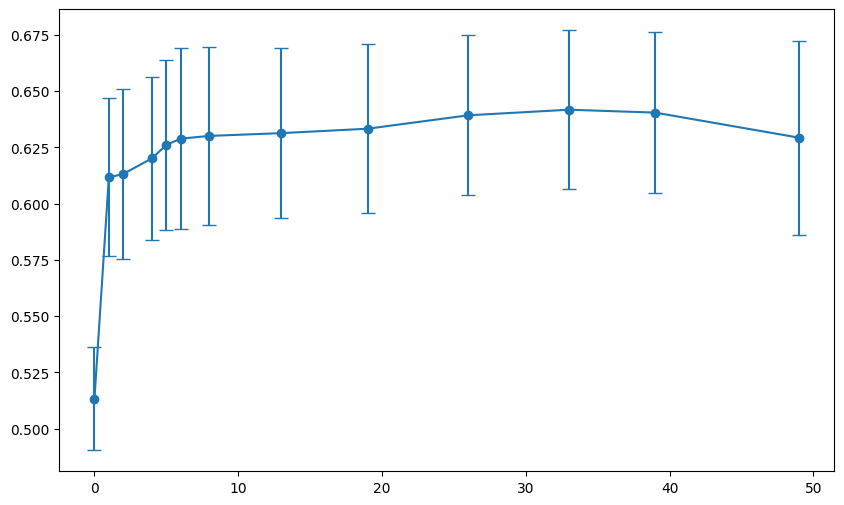

In [634]:
# plot results_df :
import matplotlib.pyplot as plt
results_df = pd.DataFrame(clf.cv_results_)

param = results_df['param_group_reg']
score = results_df['mean_test_score']
std = results_df['std_test_score']

df_plot = pd.DataFrame({
    'param': param,
    'n_selected_regions': n_selected_regions,
    'selected_regions': list_selected_regions,
    'score': score,
    'std': std
})

# with n regions, select best score only
df_plot = df_plot.sort_values(by='score', ascending=True)
df_plot = df_plot.drop_duplicates(subset='n_selected_regions', keep='last')
df_plot = df_plot.sort_values(by='n_selected_regions')

plt.figure(figsize=(10, 6))
plt.errorbar(df_plot['n_selected_regions'], df_plot['score'], yerr=df_plot['std'], fmt='o-', capsize=5)
plt.show()

In [635]:
df_plot

,param,n_selected_regions,selected_regions,score,std
17,0.85,0,[],0.513197,0.022858
14,0.70,1,[SFinf-BROCA-SPeCinf_left],0.611620,0.035150
10,0.50,2,"[SOr_left, SFinf-BROCA-SPeCinf_left]",0.613142,0.037605
9,0.45,4,"[SOr_left, SFinf-BROCA-SPeCinf_left, STi-STs-S...",0.620104,0.036196
8,0.40,5,"[SOr_left, SFinf-BROCA-SPeCinf_left, FIP_right...",0.626052,0.037827
7,0.35,6,"[SOr_left, SFinf-BROCA-SPeCinf_left, FIP_right...",0.628845,0.040143
6,0.30,8,"[SOr_left, SFinf-BROCA-SPeCinf_left, FIP_right...",0.630061,0.039408
5,0.25,13,"[SOr_left, SFinf-BROCA-SPeCinf_left, FIP_left,...",0.631291,0.037653
4,0.20,19,"[SOr_left, SOr_right, SFinf-BROCA-SPeCinf_left...",0.633256,0.037577
3,0.15,26,"[SOr_left, SOr_right, SFinf-BROCA-SPeCinf_left...",0.639219,0.035478


# Choose model and analyse selected regions : Fcoll-SRh_left, param = 0.8

In [485]:
# print coefficients associated to each region : which is most important ?
coefficients = model.coef_.reshape(-1, n_dims, 2)
coefficients = coefficients[:,:,0]
# print magnitude of coefficients for each region
coefficients_magnitude = np.sqrt(np.square(coefficients).mean(axis=1))

# convert best_regions to dataframe
best_regions_df = pd.DataFrame(best_regions, columns=['region'])
# find the indices of the selected regions in best_regions
selected_indices = [best_regions.index(region) for region in selected_regions]
coefficients_magnitude = coefficients_magnitude[selected_indices]

print('Magnitude of coefficients for each region:')
df_coefficients = pd.DataFrame({
    'region': selected_regions,
    'magnitude': coefficients_magnitude
})
print(df_coefficients.sort_values(by='magnitude', ascending=False).reset_index(drop=True))

# add invidual coefficients to df_coefficients
for i in range(n_dims):
    df_coefficients[f'dim{i+1}'] = coefficients[selected_indices, i]

Magnitude of coefficients for each region:
                region  magnitude
0       FColl-SRh_left   0.009167
1             SOr_left   0.003721
2           SPeC_right   0.002892
3             STs_left   0.002203
4            FIP_right   0.001800
5  STi-STs-STpol_right   0.001680
6             FIP_left   0.001342


In [425]:
## NB : MAGNITUDE OF COEFFICIENTS MUST BE COMPARED TO VARIANCE OF DIMENSION ? BUT IT IS STANDARDIZED

In [ ]:
preds = model.predict_proba(X_test)
roc_auc = roc_auc_score(Y_test, preds[:, 1])
print(roc_auc)

0.6468362810933509


In [486]:
## train / val auc ? peu d'overfit !!
preds_train_val = model.predict_proba(X_train)
roc_auc_train_val = roc_auc_score(Y_train, preds_train_val[:, 1])
print(roc_auc_train_val)

0.712129124139568


In [375]:
## concat predictions
df_preds_test = pd.concat([pd.DataFrame(preds[:, 1], columns=['predicted']), pd.DataFrame(Y_test, columns=['Y_true'])], axis=1)
df_preds_train_val = pd.concat([pd.DataFrame(preds_train_val[:, 1], columns=['predicted']), pd.DataFrame(Y_train, columns=['Y_true'])], axis=1)
df_preds = pd.concat([df_preds_train_val, df_preds_test], axis=0)
# add column for the subjects
df_preds['ID'] = embds_glob_train['ID_0'].tolist() + embds_glob_test['ID_0'].tolist()

In [381]:
df_preds['predicted'].describe() # predictions are very close to 0.5

count    1029.000000
mean        0.464290
std         0.068460
min         0.278150
25%         0.416182
50%         0.460200
75%         0.512758
max         0.680565
Name: predicted, dtype: float64

In [382]:
df_preds.to_csv('/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/analysis/schiz_preds_with_best_regions.csv', index=False)

# Apply further regularization with ElasticNet on the selected regions

In [453]:
dim_selected = [32*dim + k for dim in selected_indices for k in range((n_dims))]

In [454]:
X_restricted_train  = X_train.to_numpy()[:, dim_selected]
X_restricted_test = X_test.to_numpy()[:, dim_selected]

In [455]:
# apply ElasticNet gridsearch
# gridsearch cv
model = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=100)
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.],
}

In [456]:
clf = GridSearchCV(model, param_grid, cv=cv, refit=False, scoring='roc_auc', n_jobs=-1)
clf.fit(X_restricted_train, Y_train)

/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-pack

GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  16,  18,  19,  20,  21,  24,  26,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  39,  40,  41,  42,  43,  45,  46,  47,
        48,  49,  51,  52,  53,  54,  56,  57,  58,  60,  61,  62,  63,
        64,  66,  67,  68,  69,  71,  73,  77,  78,  79,  80,  83,  85,
        86,  88,  90,  91,  93,  94,  96,  97,  98,  99, 100, 102, 103,
       104, 105, 106, 107, 108, 109, 111, 112, 113, 116, 118, 119, 120,
       122, 123, 125, 126, 128, 129, 130, 131, 132, 133, 134, 13...
       674, 675, 678, 686, 689, 690, 692, 694, 701, 706, 707, 713, 729,
       730, 731, 737, 740, 747, 756, 758, 759, 761, 765, 766, 769, 771,
       774, 775, 782, 792, 795, 797, 807, 810, 812, 814]))],
             estimator=LogisticRegression(penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8, 0.9, 1.0]},
             refit=False, scoring='roc_auc')

In [457]:
best_params = clf.best_params_
print(f'Best parameters: {best_params}')
print(f'Best score: {clf.best_score_}')

Best parameters: {'C': 0.001, 'l1_ratio': 0.0}
Best score: 0.6662876265178709


# Try L2 loss instead if L1_ratio = 0

NB : it seems that both solvers find the same value ..

In [466]:
# apply ElasticNet gridsearch
# gridsearch cv
model = LogisticRegression(penalty='l2', max_iter=1000, tol=1e-6) # tolerance and max_iter don't have any impact
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [467]:
clf = GridSearchCV(model, param_grid, cv=cv, refit=False, scoring='roc_auc', n_jobs=-1)
clf.fit(X_restricted_train, Y_train)

GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  16,  18,  19,  20,  21,  24,  26,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  39,  40,  41,  42,  43,  45,  46,  47,
        48,  49,  51,  52,  53,  54,  56,  57,  58,  60,  61,  62,  63,
        64,  66,  67,  68,  69,  71,  73,  77,  78,  79,  80,  83,  85,
        86,  88,  90,  91,  93,  94,  96,  97,  98,  99, 100, 102, 103,
       104, 105, 106, 107, 108, 109, 111, 112, 113, 116, 118, 119, 120,
       122, 123, 125, 126, 128, 129, 130, 131, 132, 133, 134, 13...
       529, 530, 535, 542, 551, 558, 559, 570, 571, 574, 584, 587, 598,
       603, 606, 617, 622, 631, 632, 642, 652, 653, 654, 655, 656, 667,
       674, 675, 678, 686, 689, 690, 692, 694, 701, 706, 707, 713, 729,
       730, 731, 737, 740, 747, 756, 758, 759, 761, 765, 766, 769, 771,
       774, 775, 782, 792, 795, 797, 807, 810, 812, 814]))],
             estimator=LogisticRegression(max_iter=1000, tol=1e-06), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit=False, scoring='roc_auc')

In [469]:
best_params = clf.best_params_
print(f'Best parameters: {best_params}')
print(f'Best score: {clf.best_score_}')

Best parameters: {'C': 0.001}
Best score: 0.6662876265178709


# Use best params on best regions on test set

In [461]:
model = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=100, C=clf.best_params_['C'], l1_ratio=clf.best_params_['l1_ratio'])
model.fit(X_restricted_train, Y_train)

LogisticRegression(C=0.001, l1_ratio=0.0, penalty='elasticnet', solver='saga')

In [462]:
preds = model.predict_proba(X_restricted_test)
roc_auc = roc_auc_score(Y_test, preds[:, 1])
print(roc_auc)

0.6399319020145655


# visualize directions of classif in each region

In [383]:
df_coefficients

,region,magnitude
0,SOr_left,0.003721
1,FColl-SRh_left,0.009167
2,FIP_left,0.001342
3,STs_left,0.002203
4,FIP_right,0.001800
5,STi-STs-STpol_right,0.001680
6,SPeC_right,0.002892


In [370]:
# TODO : try knn on concat space ? (after selection of regions) ?
# is it ok to apply an elastic net on the concatenated space AFTER selection of regions ? It is not ok to evaluate twice on test set ... = data leakage

# visu 2 splits

In [79]:
def plot_horizontal_multi_splits(res, region_name, ax, p_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)


    ## iterate on Splits on same graph
    for i in range(2):
        # replace nan with 1 in res[p_value]
        res[p_value+f'{i}'] = res[p_value+f'{i}'].replace(np.nan, 1)
    
    # sort according to first split
    res = res.sort_values(by=p_value+f'0', ascending=False)
    
    for i in range(2):
        # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
        # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
        ax.axvline(x=-np.log10(0.05), color='black', linestyle='-')
        ax.axvline(x=-np.log10(0.05/56), color='red', linestyle='-')
        ax.barh(res[region_name], -np.log10(res[p_value+f'{i}']), fill=True, color='lightgray')
        ax.errorbar(-np.log10(res[p_value+f'{i}']), res[region_name], xerr=0, fmt='s')
        # if visible:
        #     ax.set_ylabel("AUC ensemble")
        # else:
        #     ax.get_yaxis().set_ticks([])
        ax.set_title(title) 
        ax.set_xlabel("-log$_{10}$(p)")

/tmp/ipykernel_2584573/2029918164.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res[p_value+f'{i}'] = res[p_value+f'{i}'].replace(np.nan, 1)


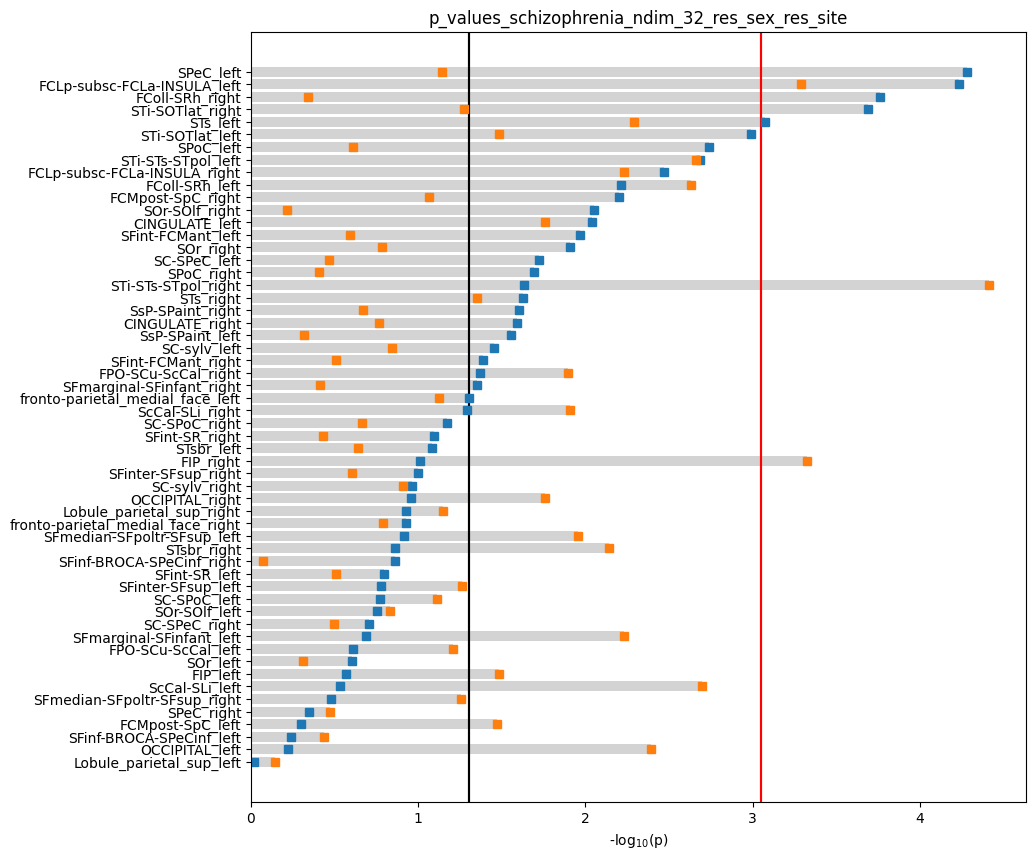

In [ ]:
# move index to column region
df_res['region'] = df_res.index
fig, ax = plt.subplots(figsize=(10,10))
plot_horizontal_multi_splits(df_res[['region', 'Split0', 'Split1']], "region", ax, "Split", True, f"p_values_{pathology}_ndim_{n_dims}_{'res_sex' if sex_residualization else ''}_{'res_site' if site_residualization else ''}")

# Regional preds (for average visu)

In [ ]:
#region = 'FCLp-subsc-FCLa-INSULA_left'
for region in preds['Split0'].keys():
    pred_split_0 = preds['Split0'][region]
    pred_split_0.to_csv(f'/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/analysis/pred_schiz/pred_schiz_{region}_split0.csv', index=False)
    pred_split_1 = preds['Split1'][region]
    pred_split_1.to_csv(f'/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/analysis/pred_schiz/pred_schiz_{region}_split1.csv', index=False)

KeyError: 'LARGE_CINGULATE_left'

In [181]:
embd

,ID,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim29,dim30,dim31,dim32,ID_labels,sex,age,diagnosis,site,ID_train_val_test
0,sub-CH1840,-1.184886,1.080916,0.531858,1.450341,0.202586,1.219537,-0.760244,0.428863,-0.725591,...,0.599098,0.422547,-0.728782,-1.068082,sub-CH1840,M,28.0,control,NU,CH1840
1,sub-CH2917,-0.073965,1.265294,1.383889,-0.199343,1.691035,0.162920,0.072214,-0.351609,0.746403,...,-0.564314,0.383791,0.545903,0.630121,sub-CH2917,M,28.0,control,NU,CH2917
2,sub-CH3098,-1.272367,1.862054,-0.049435,0.647520,1.419136,0.199635,0.546927,-0.140462,0.658954,...,-0.185915,0.166387,-0.474900,-0.578168,sub-CH3098,F,37.0,scz,NU,CH3098
3,sub-CH3183,-0.090400,0.353736,0.420314,0.153458,-0.796892,-0.619364,-0.420031,-0.707979,0.747038,...,-2.092620,-2.301501,0.425027,0.584243,sub-CH3183,M,31.0,scz,NU,CH3183
4,sub-CH7059b,-2.229034,0.207513,0.331504,0.653739,-1.202988,1.249382,1.219175,0.128740,-0.523253,...,-1.552846,1.157504,-1.347231,-0.134433,sub-CH7059b,M,33.0,control,NU,CH7059b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,sub-st110288,-0.970275,0.764355,-0.826991,1.992946,-1.022738,0.460041,1.642389,-1.708869,-0.667097,...,-1.213782,-0.380498,-0.796041,0.409987,sub-st110288,F,22.457534,scz,vip,st110288
459,sub-va110289,0.273181,-0.335419,-0.780197,0.682291,-1.461435,-0.573611,0.418445,-1.168642,-1.215557,...,-0.949388,-0.732160,-1.102657,-0.331065,sub-va110289,F,48.536986,control,vip,va110289
460,sub-ye110322,-0.011961,-0.960496,0.299691,-0.241794,-1.230511,-0.058163,0.266491,-0.402642,0.129261,...,-1.816761,0.520325,0.215739,1.148778,sub-ye110322,M,19.575342,scz,vip,ye110322
461,sub-yh100442,-0.377169,0.225729,0.326057,0.671173,0.485218,0.489736,0.135932,0.723019,-0.188143,...,1.909898,-0.409589,-1.348560,-2.574164,sub-yh100442,M,24.005479,control,vip,yh100442


# Visualization - single split

In [701]:
def plot_horizontal(res, region_name, ax, p_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    # replace nan with 1 in res[p_value]
    res[p_value] = res[p_value].replace(np.nan, 1)

    res = res.sort_values(by='p', ascending=False)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05), color='black', linestyle='-')
    ax.axvline(x=-np.log10(0.05/56), color='red', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[p_value]), fill=True, color='lightgray')
    ax.errorbar(-np.log10(res[p_value]), res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_title(title) 
    ax.set_xlabel("-log$_{10}$(p)")

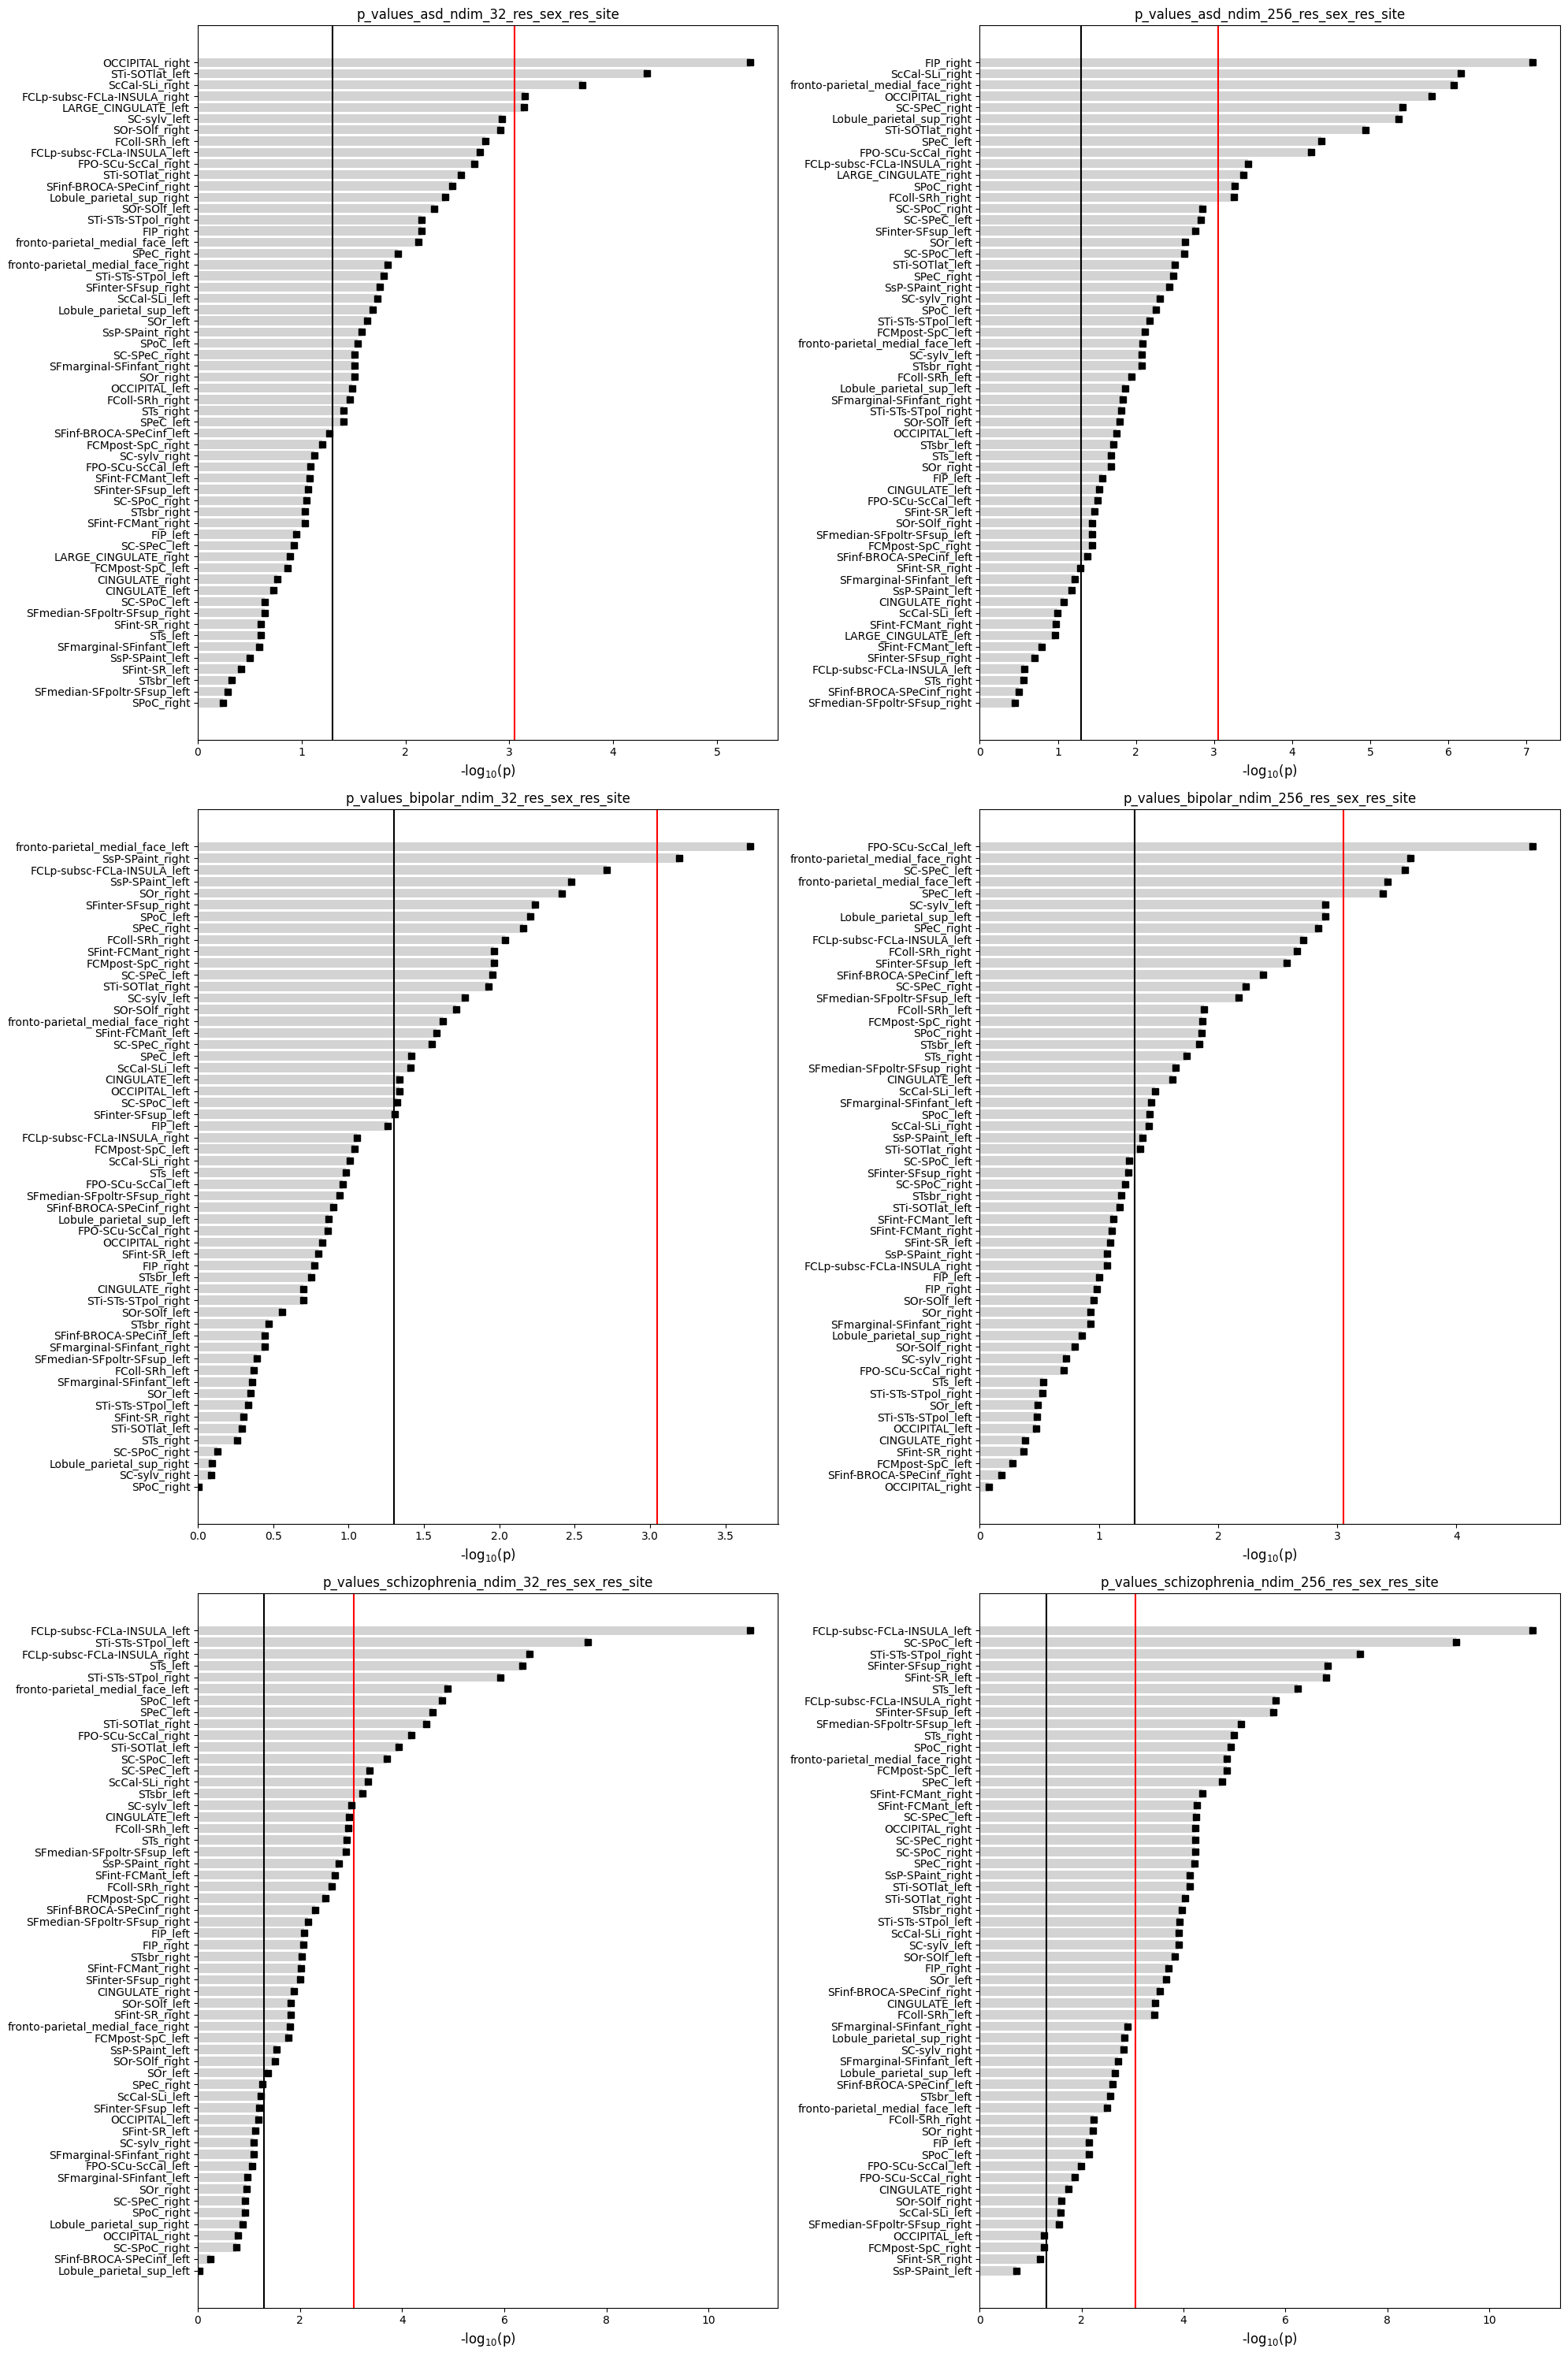

In [705]:
method = 'LinearRegression'

f, axs = plt.subplots(3, 2, figsize=(20, 30))
for i, pathology in enumerate(['asd', 'bipolar', 'schizophrenia']):
    for sex_residualization in [True]: # [True, False]
        for site_residualization in [True]: # [True, False]
            if site_residualization==True and sex_residualization==False: # don't consider this case
                pass
            else:
                for j, (n_dims, savedir) in enumerate(zip([32,256], ['/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/', '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation_latent_256/'])):

                    res = pd.read_csv(os.path.join(savedir, 'analysis', f"p_values_{pathology}_{method}_ndim_{n_dims}_{'res_sex' if sex_residualization else ''}_{'res_site' if site_residualization else ''}.csv"))
                    # move index to column
                    res = res.rename(columns={'Unnamed: 0': 'region'})

                    ax = axs[i, j]
                    plot_horizontal(res, "region", ax, "p", True, f"p_values_{pathology}_ndim_{n_dims}_{'res_sex' if sex_residualization else ''}_{'res_site' if site_residualization else ''}")
plt.rc('axes', labelsize=12) 
plt.tight_layout()
plt.show()

# Q-Q plots

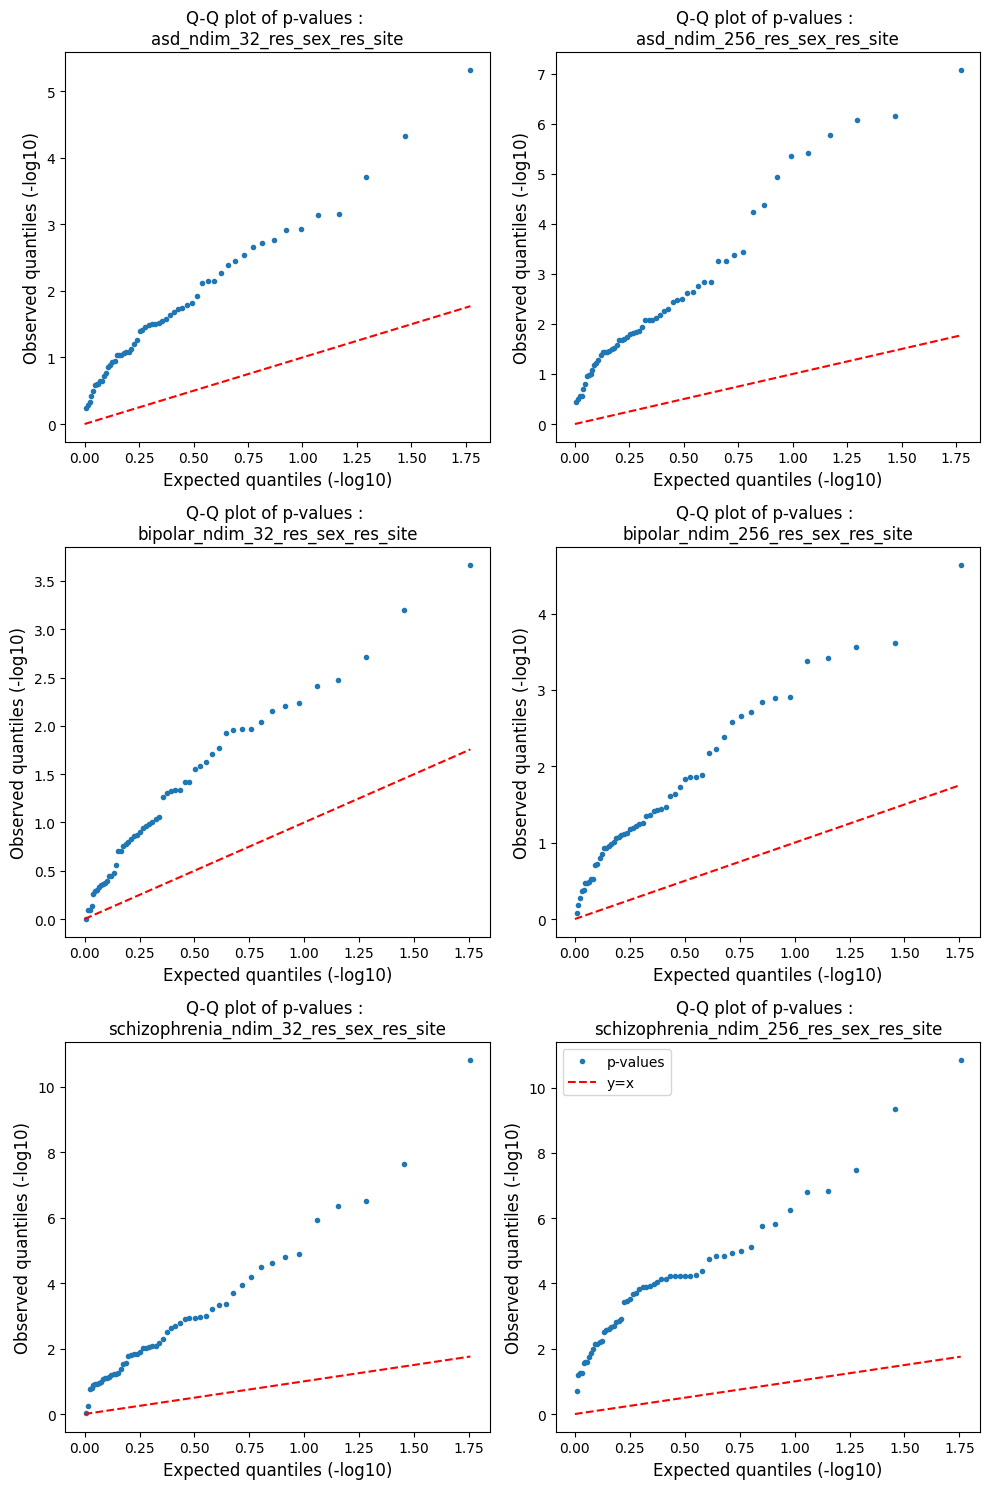

In [88]:
# loop
method = 'LinearRegression'

f, axs = plt.subplots(3, 2, figsize=(10, 15))
for i, pathology in enumerate(['asd', 'bipolar', 'schizophrenia']):
    for sex_residualization in [True]: # [True, False]
        for site_residualization in [True]: # [True, False]
            if site_residualization==True and sex_residualization==False: # don't consider this case
                pass
            else:
                for j, (n_dims, savedir) in enumerate(zip([32,256], ['/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/', '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation_latent_256/'])):

                    res = pd.read_csv(os.path.join(savedir, 'analysis', f"p_values_{pathology}_{method}_ndim_{n_dims}_{'res_sex' if sex_residualization else ''}_{'res_site' if site_residualization else ''}.csv"))
                    # move index to column
                    res = res.rename(columns={'Unnamed: 0': 'region'})
                    ax = axs[i, j]
                    # Trier les p-values observées
                    p_values_sorted = res['p']

                    # Quantiles théoriques (sous H0 : loi uniforme)
                    n = len(p_values_sorted)
                    expected = np.linspace(1/(n+1), n/(n+1), n)  # avoid 0 and 1

                    # Correction of expected values

                    # Q-Q plot
                    ax.plot(-np.log10(expected), -np.log10(p_values_sorted), 'o', markersize=3, label='p-values')
                    ax.plot([0, max(-np.log10(expected))], [0, max(-np.log10(expected))], 'r--', label='y=x')
                    ax.set_xlabel('Expected quantiles (-log10)')
                    ax.set_ylabel('Observed quantiles (-log10)')
                    ax.set_title('Q-Q plot of p-values : \n' + f"{pathology}_ndim_{n_dims}_{'res_sex' if sex_residualization else ''}_{'res_site' if site_residualization else ''}")
plt.legend()
plt.rc('axes', labelsize=12) 
plt.tight_layout()
plt.show()


# Permutation tests

In [123]:
# permute labels and report p-values
## iterate on the regions

sex_residualization = True
site_residualization = True
#method = 'LogisticRegression'
method = 'LinearRegression'

nb_iter = 100

p_values = {directory.split('/')[-4] : [] for directory in dfs_dirs}

for iter in tqdm(range(nb_iter)):

    for i, directory in enumerate(dfs_dirs):
        region = directory.split('/')[-4]
        #print(f'Treating {region}')
        try :
            embd=pd.read_csv(directory)
            embd=pd.merge(embd, df, on='ID')
            
            # fit standard scaler on embd and transform
            std = StandardScaler()
            embd_matrix = embd.loc[:, embd.columns.str.startswith('dim')]
            std_embds = std.fit_transform(embd_matrix)
            embd.loc[:, embd.columns.str.startswith('dim')] = std_embds
            #print('Length embeddings : ', embd.shape[0])

            if sex_residualization and not site_residualization:
                # residualize X regarding sex
                sex = embd['sex']
                sex = sex.apply(lambda x: 1 if x == 'M' else 0)
                resid_var = sm.add_constant(sex)
            
            if site_residualization and not sex_residualization:
                # Get dummy variables for the categorical variable
                group_dummies = pd.get_dummies(embd['site'], drop_first=True, dtype='float')
                resid_var = sm.add_constant(group_dummies)
            
            if site_residualization and sex_residualization:
                # Get dummy variables for the categorical variable
                group_dummies = pd.get_dummies(embd['site'], drop_first=True, dtype='float')
                # add sex
                sex = embd['sex']
                sex = sex.apply(lambda x: 1 if x == 'M' else 0)
                resid_var = pd.concat((group_dummies, sex), axis=1)
                resid_var = sm.add_constant(resid_var)
            
            if site_residualization or sex_residualization:
                ## residualize each latent variable
                for dim_i in [f'dim{j}' for j in range(1,n_dims+1)]:
                    # select control subjects only to perform residualization
                    y = embd[dim_i]
                    y_control = embd.loc[embd['diagnosis']=='control'][dim_i]
                    resid_var_control = resid_var.loc[embd['diagnosis']=='control']
                    results = sm.OLS(y_control, resid_var_control).fit()
                    y_pred_all = results.predict(resid_var)
                    y_resid_all = y - y_pred_all
                    embd.loc[:, dim_i] = y_resid_all
            


            X = embd.loc[:, embd.columns.str.startswith('dim')]
            Y = embd.loc[:, label]
            # assign value 1 to asd and 0 to control
            Y = Y.apply(lambda x: 0 if x == 'control' else 1)
            # shuffle Y
            if iter > 0:
                Y = np.random.permutation(Y)

            # # Add intercept
            X_const = sm.add_constant(X)

            if method=='LogisticRegression':
                # Fit the full model
                model_full = sm.Logit(Y, X_const)
                result_full = model_full.fit()
                p_value_global = result_full.llr_pvalue
            
            elif method=='LinearRegression':

                model = sm.OLS(Y, X_const)
                results = model.fit()
                f_value = results.fvalue
                p_value_global = results.f_pvalue

            p_values[region].append(p_value_global)
        except:
            print(f'Error in {directory}')
            p_values[region].append(np.nan)
            continue

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [19:04<00:00, 11.44s/it]


In [124]:
## add pvalues in dataframe
df_res = pd.DataFrame.from_dict(p_values, orient='index', columns=[f'p_{k}' for k in range(nb_iter)])

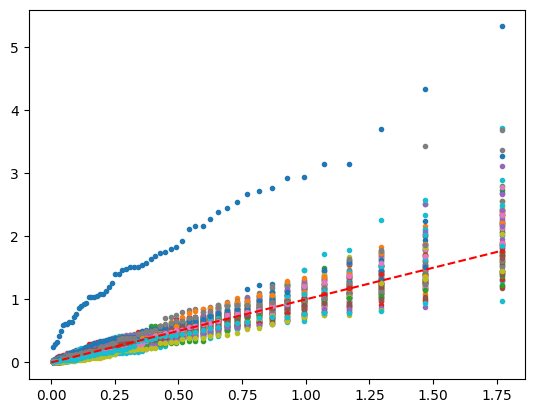

In [125]:
# for each column, draw qq plot
fig, ax = plt.subplots()
for k in range(nb_iter):
    df_res.sort_values(by=f'p_{k}', ascending=True, inplace=True)
    p_values_sorted = df_res[f'p_{k}']
    # Quantiles théoriques (sous H0 : loi uniforme)
    n = len(p_values_sorted)
    expected = np.linspace(1/(n+1), n/(n+1), n)  # avoid 0 and 1

    # Correction of expected values

    # Q-Q plot
    ax.plot(-np.log10(expected), -np.log10(p_values_sorted), 'o', markersize=3)
ax.plot([0, max(-np.log10(expected))], [0, max(-np.log10(expected))], 'r--', label='y=x')

## add real distribution


# OBSOLETE : remove female controls instead of residualization [UNREASONABLE ?]

NB : TODO, make sure that removing subjects doesn't alter the site balance ...

In [23]:
print(f"Male asd : {embd.loc[(embd['sex']=='M')&(embd['diagnosis']==pathology)].shape[0]}")
print(f"Male control : {embd.loc[(embd['sex']=='M')&(embd['diagnosis']=='control')].shape[0]}")
print(f"Female asd : {embd.loc[(embd['sex']=='F')&(embd['diagnosis']==pathology)].shape[0]}")
print(f"Female control : {embd.loc[(embd['sex']=='F')&(embd['diagnosis']=='control')].shape[0]}")

Male asd : 656
Male control : 660
Female asd : 96
Female control : 197


In [24]:
reformated_subs = pd.DataFrame()
reformated_subs['ID'] = train_val_test_subjects.apply(lambda x: 'sub-'+x['ID'], axis=1)
df = pd.merge(reformated_subs, labels, on='ID', how='left')
df = df.drop_duplicates()
df = df.dropna()

In [25]:
print(f"Male asd : {df.loc[(df['sex']=='M')&(df['diagnosis']==pathology)].shape[0]}")
print(f"Male control : {df.loc[(df['sex']=='M')&(df['diagnosis']=='control')].shape[0]}")
print(f"Female asd : {df.loc[(df['sex']=='F')&(df['diagnosis']==pathology)].shape[0]}")
print(f"Female control : {df.loc[(df['sex']=='F')&(df['diagnosis']=='control')].shape[0]}")

Male asd : 659
Male control : 662
Female asd : 96
Female control : 197


In [26]:
# remove 3 males control from df
subs_to_remove = df.loc[(df['sex']=='M')&(df['diagnosis']=='control')].sample(3, random_state=42)['ID'].tolist()
df = df.loc[~df['ID'].isin(subs_to_remove)]

# remove 101 females control from df
subs_to_remove = df.loc[(df['sex']=='F')&(df['diagnosis']=='control')].sample(101, random_state=42)['ID'].tolist()
df = df.loc[~df['ID'].isin(subs_to_remove)]

In [27]:
print(f"Male asd : {df.loc[(df['sex']=='M')&(df['diagnosis']==pathology)].shape[0]}")
print(f"Male control : {df.loc[(df['sex']=='M')&(df['diagnosis']=='control')].shape[0]}")
print(f"Female asd : {df.loc[(df['sex']=='F')&(df['diagnosis']==pathology)].shape[0]}")
print(f"Female control : {df.loc[(df['sex']=='F')&(df['diagnosis']=='control')].shape[0]}")

Male asd : 659
Male control : 659
Female asd : 96
Female control : 96


In [221]:
# check age distribution
pathology_age = df.loc[df['diagnosis']!='control']['age'].tolist()
control_age = df.loc[df['diagnosis']=='control']['age'].tolist()

print(f'mean {pathology} age : ', np.mean(pathology_age))
print('mean control age : ', np.mean(control_age))
print(f'std {pathology} age : ', np.std(pathology_age))
print('std control age : ', np.std(control_age))

mean bipolar age :  36.65243902439025
mean control age :  36.94623556869009
std bipolar age :  11.295150325711841
std control age :  13.713785109331207


In [31]:
## iterate on the regions
p_values = []
for i, directory in enumerate(tqdm(dfs_dirs)):

    embd=pd.read_csv(directory)
    # select train_val_subjects
    # add a train val label
    embd["train_val_test"] = embd['ID'].apply(lambda x: 1 if any((i in x) for i in df['ID'].tolist()) else 0)
    embd = embd.loc[embd['train_val_test'] == 1]
    embd = embd.loc[:, ~embd.columns.duplicated()]
    # fit standard scaler on embd and transform
    std = StandardScaler()
    embd_matrix = embd.loc[:, embd.columns.str.startswith('dim')]
    std_embds = std.fit_transform(embd_matrix)
    embd.loc[:, embd.columns.str.startswith('dim')] = std_embds
    embd['ID'] = embd['ID'].astype(str)
    ## restrict embeddings to one single run
    # remove the 'run' information
    embd['ID'] = embd['ID'].str.split('_ses').str[0]
    # remove rows with duplicate ID ## SOME SUBJECTS HAVE MULTIPLE RUNS
    embd = embd.drop_duplicates(subset=['ID'], keep='first')
    # add label + confounders
    embd = pd.merge(embd, labels, on='ID', how='left')
    embd = embd.dropna()

    X = embd.loc[:, embd.columns.str.startswith('dim')]
    Y = embd.loc[:, label]
    # assign value 1 to asd and 0 to control
    Y = Y.apply(lambda x: 0 if x == 'control' else 1)

    # # Add intercept
    X_const = sm.add_constant(X)

    # Fit the full model
    model_full = sm.Logit(Y, X_const)
    result_full = model_full.fit()
    p_value_global = result_full.llr_pvalue

    p_values.append(p_value_global)

  2%|▏         | 1/58 [00:00<00:14,  3.92it/s]

Optimization terminated successfully.
         Current function value: 0.683302
         Iterations 4


  3%|▎         | 2/58 [00:00<00:22,  2.51it/s]

Optimization terminated successfully.
         Current function value: 0.684358
         Iterations 4


  5%|▌         | 3/58 [00:01<00:23,  2.36it/s]

Optimization terminated successfully.
         Current function value: 0.676927
         Iterations 5


  7%|▋         | 4/58 [00:01<00:23,  2.30it/s]

Optimization terminated successfully.
         Current function value: 0.672905
         Iterations 5


  9%|▊         | 5/58 [00:02<00:21,  2.48it/s]

Optimization terminated successfully.
         Current function value: 0.680811
         Iterations 4


 10%|█         | 6/58 [00:02<00:19,  2.69it/s]

Optimization terminated successfully.
         Current function value: 0.682887
         Iterations 4


 12%|█▏        | 7/58 [00:02<00:17,  2.85it/s]

Optimization terminated successfully.
         Current function value: 0.673267
         Iterations 4


 14%|█▍        | 8/58 [00:02<00:16,  3.00it/s]

Optimization terminated successfully.
         Current function value: 0.677811
         Iterations 4


 16%|█▌        | 9/58 [00:03<00:15,  3.16it/s]

Optimization terminated successfully.
         Current function value: 0.678946
         Iterations 4


 17%|█▋        | 10/58 [00:03<00:15,  3.19it/s]

Optimization terminated successfully.
         Current function value: 0.676632
         Iterations 4


 19%|█▉        | 11/58 [00:03<00:14,  3.22it/s]

Optimization terminated successfully.
         Current function value: 0.679063
         Iterations 4


 21%|██        | 12/58 [00:04<00:14,  3.22it/s]

Optimization terminated successfully.
         Current function value: 0.676017
         Iterations 5


 22%|██▏       | 13/58 [00:04<00:13,  3.25it/s]

Optimization terminated successfully.
         Current function value: 0.679511
         Iterations 4


 24%|██▍       | 14/58 [00:04<00:13,  3.20it/s]

Optimization terminated successfully.
         Current function value: 0.684576
         Iterations 4


 26%|██▌       | 15/58 [00:05<00:13,  3.26it/s]

Optimization terminated successfully.
         Current function value: 0.677048
         Iterations 4


 28%|██▊       | 16/58 [00:05<00:14,  2.96it/s]

Optimization terminated successfully.
         Current function value: 0.676180
         Iterations 4


 29%|██▉       | 17/58 [00:05<00:13,  3.07it/s]

Optimization terminated successfully.
         Current function value: 0.680309
         Iterations 4


 31%|███       | 18/58 [00:06<00:12,  3.23it/s]

Optimization terminated successfully.
         Current function value: 0.671707
         Iterations 5


 33%|███▎      | 19/58 [00:06<00:11,  3.31it/s]

Optimization terminated successfully.
         Current function value: 0.682002
         Iterations 4


 34%|███▍      | 20/58 [00:06<00:11,  3.39it/s]

Optimization terminated successfully.
         Current function value: 0.678927
         Iterations 4


 36%|███▌      | 21/58 [00:06<00:10,  3.38it/s]

Optimization terminated successfully.
         Current function value: 0.680467
         Iterations 4


 38%|███▊      | 22/58 [00:07<00:10,  3.41it/s]

Optimization terminated successfully.
         Current function value: 0.680288
         Iterations 4


 40%|███▉      | 23/58 [00:07<00:10,  3.46it/s]

Optimization terminated successfully.
         Current function value: 0.678572
         Iterations 4


 41%|████▏     | 24/58 [00:07<00:09,  3.51it/s]

Optimization terminated successfully.
         Current function value: 0.681218
         Iterations 4


 43%|████▎     | 25/58 [00:07<00:09,  3.56it/s]

Optimization terminated successfully.
         Current function value: 0.681082
         Iterations 4


 45%|████▍     | 26/58 [00:08<00:08,  3.57it/s]

Optimization terminated successfully.
         Current function value: 0.675927
         Iterations 4


 47%|████▋     | 27/58 [00:08<00:08,  3.57it/s]

Optimization terminated successfully.
         Current function value: 0.684820
         Iterations 4


 48%|████▊     | 28/58 [00:08<00:08,  3.42it/s]

Optimization terminated successfully.
         Current function value: 0.681940
         Iterations 4


 50%|█████     | 29/58 [00:09<00:08,  3.36it/s]

Optimization terminated successfully.
         Current function value: 0.685402
         Iterations 4


 52%|█████▏    | 30/58 [00:09<00:08,  3.42it/s]

Optimization terminated successfully.
         Current function value: 0.679484
         Iterations 4


 53%|█████▎    | 31/58 [00:09<00:07,  3.48it/s]

Optimization terminated successfully.
         Current function value: 0.678307
         Iterations 4


 55%|█████▌    | 32/58 [00:10<00:07,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.679981
         Iterations 4


 57%|█████▋    | 33/58 [00:10<00:06,  3.58it/s]

Optimization terminated successfully.
         Current function value: 0.678933
         Iterations 4


 59%|█████▊    | 34/58 [00:10<00:06,  3.59it/s]

Optimization terminated successfully.
         Current function value: 0.681905
         Iterations 4


 60%|██████    | 35/58 [00:10<00:06,  3.54it/s]

Optimization terminated successfully.
         Current function value: 0.683241
         Iterations 4


 62%|██████▏   | 36/58 [00:11<00:06,  3.59it/s]

Optimization terminated successfully.
         Current function value: 0.682229
         Iterations 4


 64%|██████▍   | 37/58 [00:11<00:05,  3.59it/s]

Optimization terminated successfully.
         Current function value: 0.674836
         Iterations 4


 66%|██████▌   | 38/58 [00:11<00:05,  3.59it/s]

Optimization terminated successfully.
         Current function value: 0.677145
         Iterations 4


 67%|██████▋   | 39/58 [00:11<00:05,  3.62it/s]

Optimization terminated successfully.
         Current function value: 0.677028
         Iterations 4


 69%|██████▉   | 40/58 [00:12<00:04,  3.64it/s]

Optimization terminated successfully.
         Current function value: 0.678040
         Iterations 4


 71%|███████   | 41/58 [00:12<00:04,  3.65it/s]

Optimization terminated successfully.
         Current function value: 0.677958
         Iterations 4


 72%|███████▏  | 42/58 [00:12<00:04,  3.65it/s]

Optimization terminated successfully.
         Current function value: 0.679051
         Iterations 4


 74%|███████▍  | 43/58 [00:13<00:04,  3.66it/s]

Optimization terminated successfully.
         Current function value: 0.680945
         Iterations 4


 76%|███████▌  | 44/58 [00:13<00:03,  3.67it/s]

Optimization terminated successfully.
         Current function value: 0.683649
         Iterations 4


 78%|███████▊  | 45/58 [00:13<00:03,  3.69it/s]

Optimization terminated successfully.
         Current function value: 0.673107
         Iterations 4


 79%|███████▉  | 46/58 [00:13<00:03,  3.69it/s]

Optimization terminated successfully.
         Current function value: 0.676381
         Iterations 4


 81%|████████  | 47/58 [00:14<00:02,  3.69it/s]

Optimization terminated successfully.
         Current function value: 0.675901
         Iterations 4


 83%|████████▎ | 48/58 [00:14<00:02,  3.69it/s]

Optimization terminated successfully.
         Current function value: 0.672736
         Iterations 4


 84%|████████▍ | 49/58 [00:14<00:02,  3.68it/s]

Optimization terminated successfully.
         Current function value: 0.681390
         Iterations 4


 86%|████████▌ | 50/58 [00:14<00:02,  3.67it/s]

Optimization terminated successfully.
         Current function value: 0.676166
         Iterations 4


 88%|████████▊ | 51/58 [00:15<00:01,  3.66it/s]

Optimization terminated successfully.
         Current function value: 0.683137
         Iterations 4


 90%|████████▉ | 52/58 [00:15<00:01,  3.64it/s]

Optimization terminated successfully.
         Current function value: 0.676952
         Iterations 4


 91%|█████████▏| 53/58 [00:15<00:01,  3.66it/s]

Optimization terminated successfully.
         Current function value: 0.677628
         Iterations 4


 93%|█████████▎| 54/58 [00:16<00:01,  3.68it/s]

Optimization terminated successfully.
         Current function value: 0.675865
         Iterations 4


 95%|█████████▍| 55/58 [00:16<00:00,  3.68it/s]

Optimization terminated successfully.
         Current function value: 0.680831
         Iterations 4


 97%|█████████▋| 56/58 [00:16<00:00,  3.60it/s]

Optimization terminated successfully.
         Current function value: 0.683324
         Iterations 4


 98%|█████████▊| 57/58 [00:16<00:00,  3.24it/s]

Optimization terminated successfully.
         Current function value: 0.676562
         Iterations 4


100%|██████████| 58/58 [00:17<00:00,  3.36it/s]

Optimization terminated successfully.
         Current function value: 0.681640
         Iterations 4


In [32]:
## add pvalues in dataframe
regions = [directory.split('/')[-4] for directory in dfs_dirs]
df_res = pd.DataFrame({'region': regions, 'p': p_values})

In [33]:
df_res.sort_values(by='p', ascending=True, inplace=True)

In [34]:
df_res

,region,p
17,OCCIPITAL_right,0.000569
47,STi-STs-STpol_right,0.001329
3,FCLp-subsc-FCLa-INSULA_right,0.001522
44,STi-SOTlat_left,0.001790
6,FColl-SRh_left,0.002032
36,SOr-SOlf_left,0.006749
53,ScCal-SLi_right,0.014109
46,STi-STs-STpol_left,0.014465
25,SFinf-BROCA-SPeCinf_right,0.014731
11,FPO-SCu-ScCal_right,0.015679


In [ ]:
df_res.to_csv(os.path.join(savedir, f'p_values_{pathology}_with_balance_without_residualization_ndim_{n_dims}.csv'), index=False)